# Preference Learning - Part II
## 1. Principle Component Analysis (PCA)
## 2. Gaussian Mixture Models (GMM)
## 3. Groups' Price Responsiveness

In [1]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
from pandas.io.json import json_normalize #package for flattening json in pandas df
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime

## 1. Principle Component Analysis
We first focus on the non-event data. For each hour, 

(1) the first approach is we do principle component analysis and get several explanable top PCs and then use the top PCs to do K-mean clustering to find out groups; 

(2) the second approach is forget about PCA, and start by drawing histogram of distribution on a temp, consumption, occurence 3D space, and using GMM to fit the data and find out the classes.

In [2]:
# Import all preprocessed data necessary for the analysis
df_tou1h = pd.read_csv("C:\\Users\\Rockwell\\Desktop\\Paper4\\data_collection\\data_tables\\Consumption_tou2013_1h.csv")
df_Ntou1h = pd.read_csv("C:\\Users\\Rockwell\\Desktop\\Paper4\\data_collection\\data_tables\\Consumption_Ntou2013_1h.csv")
df_wea1h = pd.read_csv("C:\\Users\\Rockwell\\Desktop\\Paper4\\data_collection\\weather\\LondonWeather2013_interpolated.csv")
df_tariff_1h = pd.read_csv("C:\\Users\\Rockwell\\Desktop\\Paper4\\data_collection\\data_tables\\df_tariff_1h.csv")

In [2]:
import os
os.getcwd()

'/Users/Rockwell/Documents/GitHub/Demand-Response'

In [3]:
# for ios system, import all data necessary for the analysis
df_tou1h = pd.read_csv('/Users/Rockwell/Desktop/PhD/Paper4PreferenceLearning/data/Consumption_tou2013_1h.csv')
df_Ntou1h = pd.read_csv('/Users/Rockwell/Desktop/PhD/Paper4PreferenceLearning/data/Consumption_Ntou2013_1h.csv')
df_wea1h = pd.read_csv('/Users/Rockwell/Desktop/PhD/Paper4PreferenceLearning/data/LondonWeather2013_interpolated.csv')
df_tariff_1h = pd.read_csv('/Users/Rockwell/Desktop/PhD/Paper4PreferenceLearning/data/df_tariff_1h.csv')

In [3]:
# first, create a list of days that belongs to event days
event_days = set()
event_series = df_tariff_1h[df_tariff_1h.Event_tags.notnull()].GMT
for i in event_series:
    event_days.add(datetime.strptime(i[:10], "%Y-%m-%d" ).date()) # add all event dates to the set
df_help = pd.DataFrame(pd.to_datetime(df_tariff_1h.GMT).dt.date) #str to datatime and extract date then make it to dataframe
# df_help[df_help['GMT'].isin(event_days)] #this shows the event days
# we can use ~df_help['GMT'].isin(event_days) to generate any non-flexible period items

# create TOU and non-TOU demand data in non-flexible hours
df_wea1h_nf = df_wea1h[~df_help['GMT'].isin(event_days)]
df_Ntou1h_nf = df_Ntou1h[~df_help['GMT'].isin(event_days)]
df_tou1h_nf = df_tou1h[~df_help['GMT'].isin(event_days)]

In [4]:
# seperate the above data set based on the seasonal effect
# i.e., months of 11, 12, 1, 2, 3 are in a group - cold season
# months of 4, 5, 6, 7, 8, 9, 10 are in another group - warm season
cold_season = [11, 12, 1, 2, 3]
warm_season = [4, 5, 6, 7, 8, 9, 10]
df_help_season = pd.DataFrame(pd.to_datetime(df_wea1h_nf.GMT).dt.month)
df_wea1h_nf_cold = df_wea1h_nf[df_help_season['GMT'].isin(cold_season)]
df_wea1h_nf_warm = df_wea1h_nf[df_help_season['GMT'].isin(warm_season)]
df_Ntou1h_nf_cold = df_Ntou1h_nf[df_help_season['GMT'].isin(cold_season)]
df_Ntou1h_nf_warm = df_Ntou1h_nf[df_help_season['GMT'].isin(warm_season)]
df_tou1h_nf_cold = df_tou1h_nf[df_help_season['GMT'].isin(cold_season)]
df_tou1h_nf_warm = df_tou1h_nf[df_help_season['GMT'].isin(warm_season)]

(1) In PCA, we don't consider normalization since all the consumptions have the same unit, we care about the absolute change rather than relative change since DR targets the customer who has largest potential shiftable load instead of largest price-responsiveness rate. Also we have seperate data by hours, so the temp-consumption relationship at different hours has been treated seprately and equally, so the time effect won't be a concern to let us normalize the data.

In [5]:
df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains('09:00:00')].transpose()

9                    33                   57    \
GMT    2013-01-01 09:00:00  2013-01-02 09:00:00  2013-01-03 09:00:00   
D0000                0.178                0.092                0.484   
D0001                0.463                0.469                0.604   
D0002                0.482                0.495                0.463   
D0003                0.153                0.152                0.451   
D0004                0.231                0.309                0.342   
D0005                0.136                0.367                0.267   
D0006                0.096                0.244                0.701   
D0007                0.177                0.191                0.425   
D0008                0.168                 0.33                 0.25   
D0009                0.108                0.203                0.184   
D0010                0.018                0.027                0.022   
D0011                0.354                0.475                0.088   
D0012                0.311                0.197                0.129   
D0013                0.132                0.136                0.134   
D0014                0.697                2.076                1.152   
D0015                0.186                0.195                0.205   
D0016                0.071                0.221                0.067   
D0017                0.103                 0.18                0.297   
D0018                 0.05                0.108                 0.18   
D0019                0.943                 3.24                2.709   
D0020                1.575                2.274                1.132   
D0021                0.079                    0                0.037   
D0022                0.642                0.217                0.324   
D0023                0.467                1.046                0.687   
D0024                0.071                0.068                0.069   
D0025                 1.48                1.077                1.088   
D0026                0.088                0.094                0.107   
D0027                0.198                0.187                0.174   
D0028                0.513                0.665                0.463   
...                    ...                  ...                  ...   
D0995                0.159                0.056                0.056   
D0996                0.813                2.727                2.918   
D0997                0.384                0.826                 0.46   
D0998                0.679                0.561                0.556   
D0999                0.169                0.451                  0.3   
D1000                0.733                0.368                0.375   
D1001                1.004                2.631                0.652   
D1002                1.871                0.269                0.346   
D1003                0.203                0.235                0.275   
D1004                0.048                0.054                 0.32   
D1005                3.933                2.882                 1.57   
D1006                 0.21                0.117                0.133   
D1007                  0.4                0.142                0.167   
D1008                0.311                0.118                0.494   
D1009                0.713                0.517                0.515   
D1010                0.268                0.275                0.268   
D1011                0.347                0.294                0.316   
D1012                0.114                0.077                0.164   
D1013                1.217                1.255                0.941   
D1014                 0.34                0.629                0.835   
D1015                0.062                0.043                 0.07   
D1016                0.106                0.255                0.252   
D1017                0.245                0.207                0.207   
D1018                0.251                0.397               

In [80]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# Test with 9:00 am TOU data
x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains('09:00:00')]
x.set_index('GMT', inplace = True)
x = x.transpose().dropna() # data for the specific hour, and filtering out null value
x = x.values
x = StandardScaler().fit_transform(x)
pca = PCA()# keep all columns to cover 100% variance
principleComponents = pca.fit_transform(x)
principleDf = pd.DataFrame(data = principleComponents)
principleDf

0          1         2         3         4         5         6   \
0    -4.534874   0.453149 -0.791187  0.190559 -0.019240 -0.216637  0.002832   
1    -2.259145  -0.894439  0.065706 -1.158057 -0.169163 -0.384709  0.269293   
2     6.623904   0.566495  2.227523  0.283639  1.263913  0.823391 -1.208211   
3    -2.740304   1.903443  0.820230  0.305847  0.466140 -0.485148 -0.582654   
4    -3.662682  -0.357209  1.408946 -0.311664  0.480621 -0.457705 -0.179151   
5    -2.355763  -0.460153 -0.311662  0.083363  0.184648 -0.127965  0.004612   
6    -1.970082   0.457461 -1.200723 -0.310279  0.513020 -0.830899  0.089446   
7    -0.681808   0.273903 -0.735341 -0.149064  0.061141 -0.226158 -0.949310   
8    -3.266754   0.000133 -0.386045 -0.399162  0.111960  0.136354 -0.249222   
9     0.400567   0.209370  1.729419  2.746633 -0.107041  0.326880 -2.408428   
10   -7.042212   0.513386 -0.329802 -0.132723  0.213440  0.120629 -0.109313   
11    0.233345   0.855499 -0.241367  0.765003 -0.745088  1.305379 -0.492979   
12   -4.007395   0.560723 -0.013456  0.084144  0.103276  0.401981 -0.276543   
13   -2.853565  -1.664745  0.897125  0.519937  0.507544  0.861155  0.032013   
14   14.498900   0.299989 -4.448355  0.502973 -1.332026 -0.198652  0.147603   
15    2.167650  -4.180741 -1.749307 -0.316495 -0.322945 -0.869980 -1.531033   
16   -3.728301   0.842762  1.856092  0.690502  0.491812 -0.314615 -1.004052   
17    4.102987  -2.643518  2.886709 -2.894087  1.265600  1.237621 -1.494439   
18   -3.537458   0.893724 -0.240811  0.052045 -0.686409  0.384680  0.823733   
19    2.104148   0.195389  0.866380 -1.255357 -2.038346 -2.907979  2.075851   
20   18.303541   1.400164  1.849293 -1.700998 -3.301577 -1.747596 -2.234843   
21   -7.036772   0.820405 -0.274520 -0.138987  0.191607  0.098103 -0.153313   
22   -1.505614  -0.739888 -0.101177 -0.872268  0.550156 -0.098609  0.257770   
23    3.064493  -2.394037 -0.082017 -0.240338 -0.637217 -0.119054 -1.175948   
24   -4.936588   0.606600  0.143683 -0.319888 -0.021122  0.405841 -0.322089   
25   10.108856  -2.332781  1.813273  0.670830 -0.616196  0.537470  0.732115   
26   -5.530083   0.445816 -0.194528 -0.177582  0.144911  0.115361 -0.177564   
27   -3.317530  -0.038190  0.537351  0.077267  0.076375  0.247581 -0.191911   
28    0.370119  -0.531714  1.452065 -0.382532 -0.532530 -0.521505  0.405743   
29   25.094028  10.211609  1.506032 -2.422289 -0.762213 -2.541431  1.238837   
..         ...        ...       ...       ...       ...       ...       ...   
928  13.153705  -6.122491 -0.936893 -0.067435 -0.633626  0.444703 -1.677814   
929  -2.935874   0.929708 -0.035909 -0.426892  0.195084  0.755464 -0.311774   
930  14.075726  -3.518164  1.727959 -3.201588  0.034378 -3.397127  2.803022   
931   4.000995  -1.277612  0.686759 -0.758089  0.612863 -0.422578 -0.604598   
932   0.990693  -0.609995  1.340742  0.791783 -0.574173 -0.493437 -0.166120   
933  -2.485661   0.454496 -0.349028 -0.349391  0.310378 -0.243987  0.773327   
934  -0.658207  -0.871539 -0.448679 -0.330381 -0.316628 -0.433882  0.220438   
935   8.663549   0.613845  0.162767 -0.009711 -0.905966  0.181044 -0.423802   
936  13.605658  -2.656613  0.092270 -0.501913  2.020198 -0.034162  0.872248   
937  -2.568863  -0.541209  1.502244  0.326071  0.042381 -0.291426 -0.925268   
938  -4.380465  -0.369758  0.206026 -0.143376  0.603609 -0.009522 -0.220267   
939   9.738359   6.188866  1.601376 -2.638353 -5.047227 -2.608289  2.424325   
940  -4.344584   0.826550 -0.204983  0.202969  0.327891 -0.015496 -0.095289   
941  -3.352356   0.557025  0.554580  0.762879 -0.097865 -0.517873  0.526028   
942   0.833003  -0.867532  0.201552  0.921370  1.403132  0.170312 -0.170834   
943   3.459084  -0.223873 -0.722817  0.214997  0.664079  0.480794  0.778462   
944   0.564098  -1.554118 -1.787215  1.933966 -0.155582  0.420222  1.638490   
945   0.468435  -1.730717 -0.236668  0.139935  0.304885 -0.202096 -0.610773   
946  -2.229655   0.545837  0.165733  0.765799  0.827582  0.113

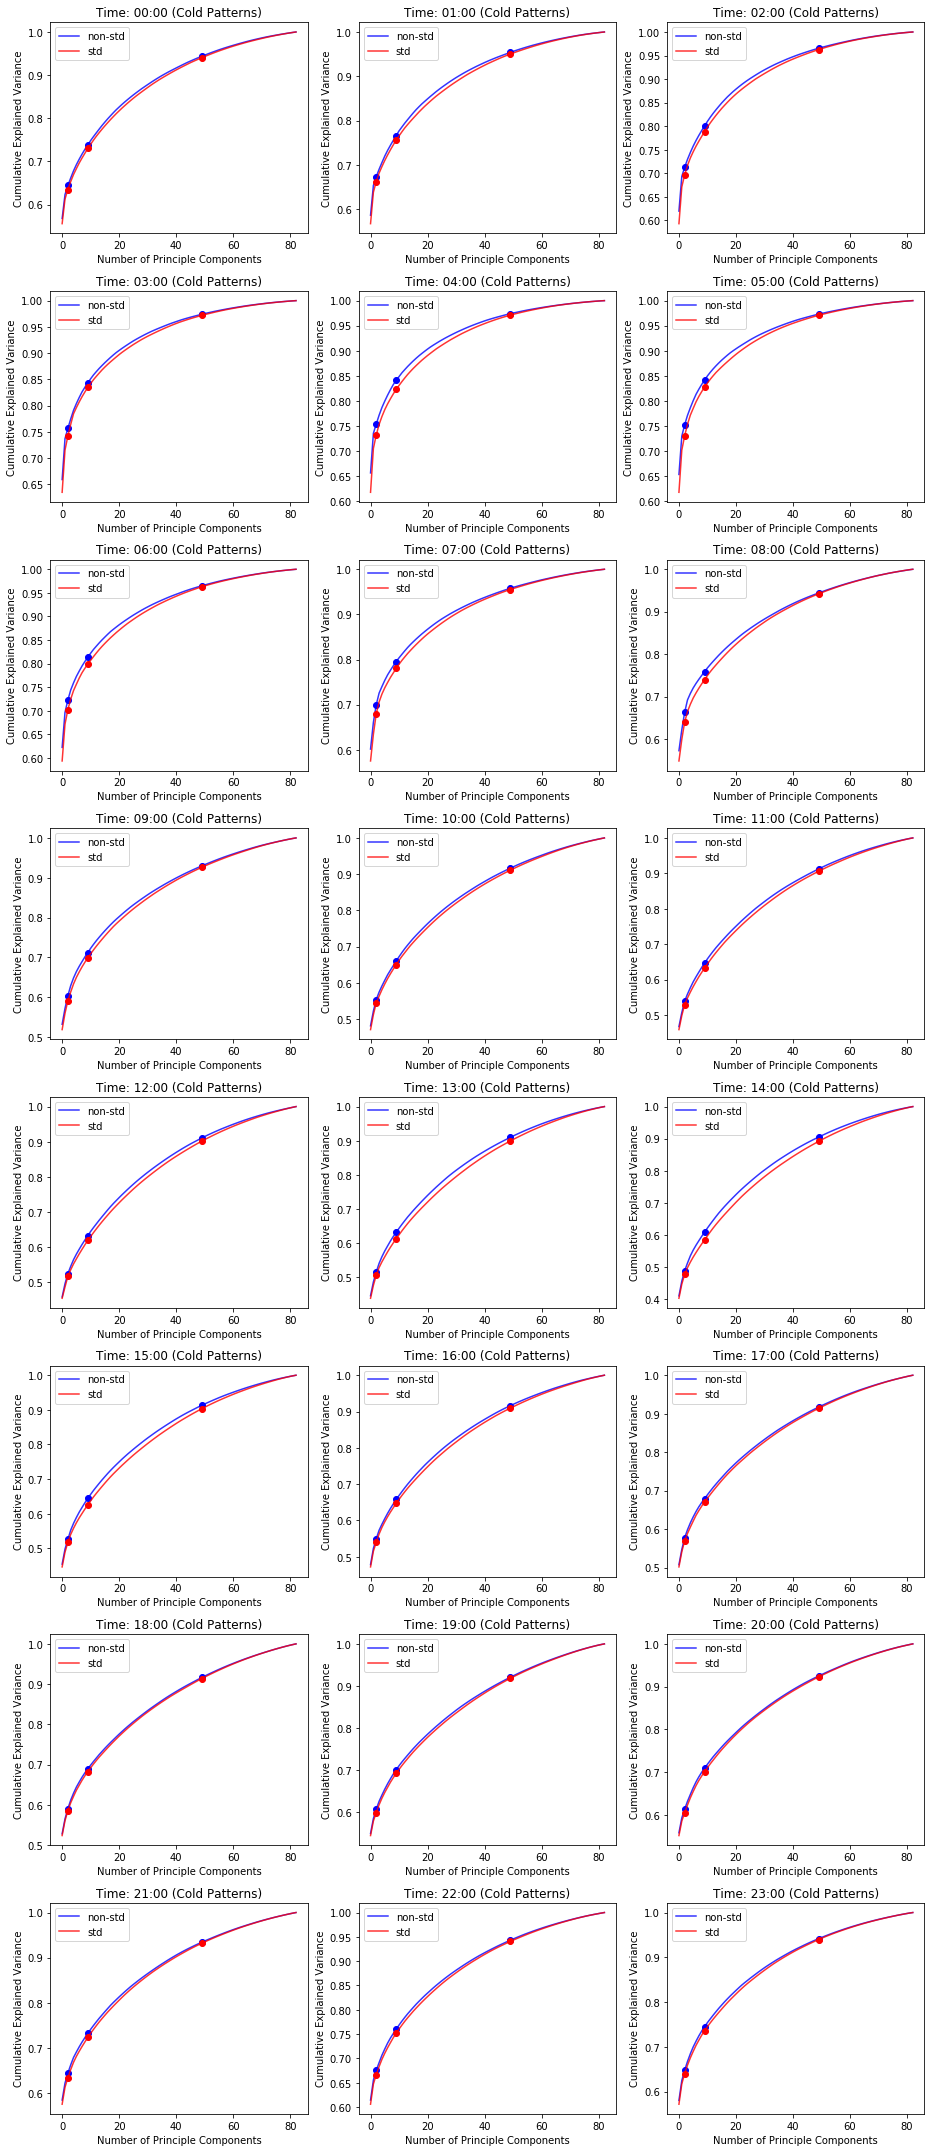

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

fig_all = plt.figure(figsize = (13,30))
for i in range(24):
    ax = fig_all.add_subplot(8, 3, i + 1)
    if i <= 9:
        x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains('0' + str(i) + ':00:00')]
        x.set_index('GMT', inplace = True)
        x = x.transpose().dropna() # data for the specific hour, and filtering out null value
        # PCA without standardization
        pca_nstd = PCA()
        principleComponents_nstd = pca_nstd.fit_transform(x)
        principleDf_nstd = pd.DataFrame(data = principleComponents_nstd)
        ax.plot(np.cumsum(pca_nstd.explained_variance_ratio_), c = 'blue', label = 'non-std', alpha = 0.8)
        ax.plot([2, 9, 49], [np.cumsum(pca_nstd.explained_variance_ratio_)[2], np.cumsum(pca_nstd.explained_variance_ratio_)[9], np.cumsum(pca_nstd.explained_variance_ratio_)[49]], 'bo')
        # PCA with standardization
        x = x.values
        x = StandardScaler().fit_transform(x)
        pca = PCA()# keep all columns to cover 100% variance
        principleComponents = pca.fit_transform(x)
        principleDf = pd.DataFrame(data = principleComponents)
        ax.plot(np.cumsum(pca.explained_variance_ratio_), c = 'red', label = 'std', alpha = 0.8)
        ax.plot([2, 9, 49], [np.cumsum(pca.explained_variance_ratio_)[2], np.cumsum(pca.explained_variance_ratio_)[9], np.cumsum(pca.explained_variance_ratio_)[49]], 'ro')
        ax.set_title('Time: 0' + str(i) + ':00' + ' (Cold Patterns)')
        ax.legend()
        ax.set_xlabel('Number of Principle Components')
        ax.set_ylabel('Cumulative Explained Variance')
    else:
        x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains(str(i) + ':00:00')]
        x.set_index('GMT', inplace = True)
        x = x.transpose().dropna() # data for the specific hour, and filtering out null value
        # PCA without standardization
        pca_nstd = PCA()
        principleComponents_nstd = pca_nstd.fit_transform(x)
        principleDf_nstd = pd.DataFrame(data = principleComponents_nstd)
        ax.plot(np.cumsum(pca_nstd.explained_variance_ratio_), c = 'blue', label = 'non-std', alpha = 0.8)
        ax.plot([2, 9, 49], [np.cumsum(pca_nstd.explained_variance_ratio_)[2], np.cumsum(pca_nstd.explained_variance_ratio_)[9], np.cumsum(pca_nstd.explained_variance_ratio_)[49]], 'bo')
        # PCA with standardization
        x = x.values
        x = StandardScaler().fit_transform(x)
        pca = PCA()# keep all columns to cover 100% variance
        principleComponents = pca.fit_transform(x)
        principleDf = pd.DataFrame(data = principleComponents)
        ax.plot(np.cumsum(pca.explained_variance_ratio_), c = 'red', label = 'std', alpha = 0.8)
        ax.plot([2, 9, 49], [np.cumsum(pca.explained_variance_ratio_)[2], np.cumsum(pca.explained_variance_ratio_)[9], np.cumsum(pca.explained_variance_ratio_)[49]], 'ro')
        ax.set_title('Time: ' + str(i) + ':00' + ' (Cold Patterns)')
        ax.legend()
        ax.set_xlabel('Number of Principle Components')
        ax.set_ylabel('Cumulative Explained Variance')
plt.tight_layout()

The above pictures show that using the first 3 PCs can always explain from 48% to 72% amount of variance. 

Next we will give the meaning of the first 3 PCs:

PC1 & PC2: temperature related (no matter of standarization, PC1 and PC2 are somehow correlated)

PC3: related to days of week, since the coeffients of Friday and Saturday are skewied to positive area, if there's not correlation, it should always be equally distributed around 0

Using the 3 components to do k-mean clustering and we can get several groups

Coloring them in a 3D space (or if the first two PCs leads to some confustion, maybe do 2D with 3 differnt projections)

Then we could try to color them in a 2D slice surphase (temp vs day of week, temp )


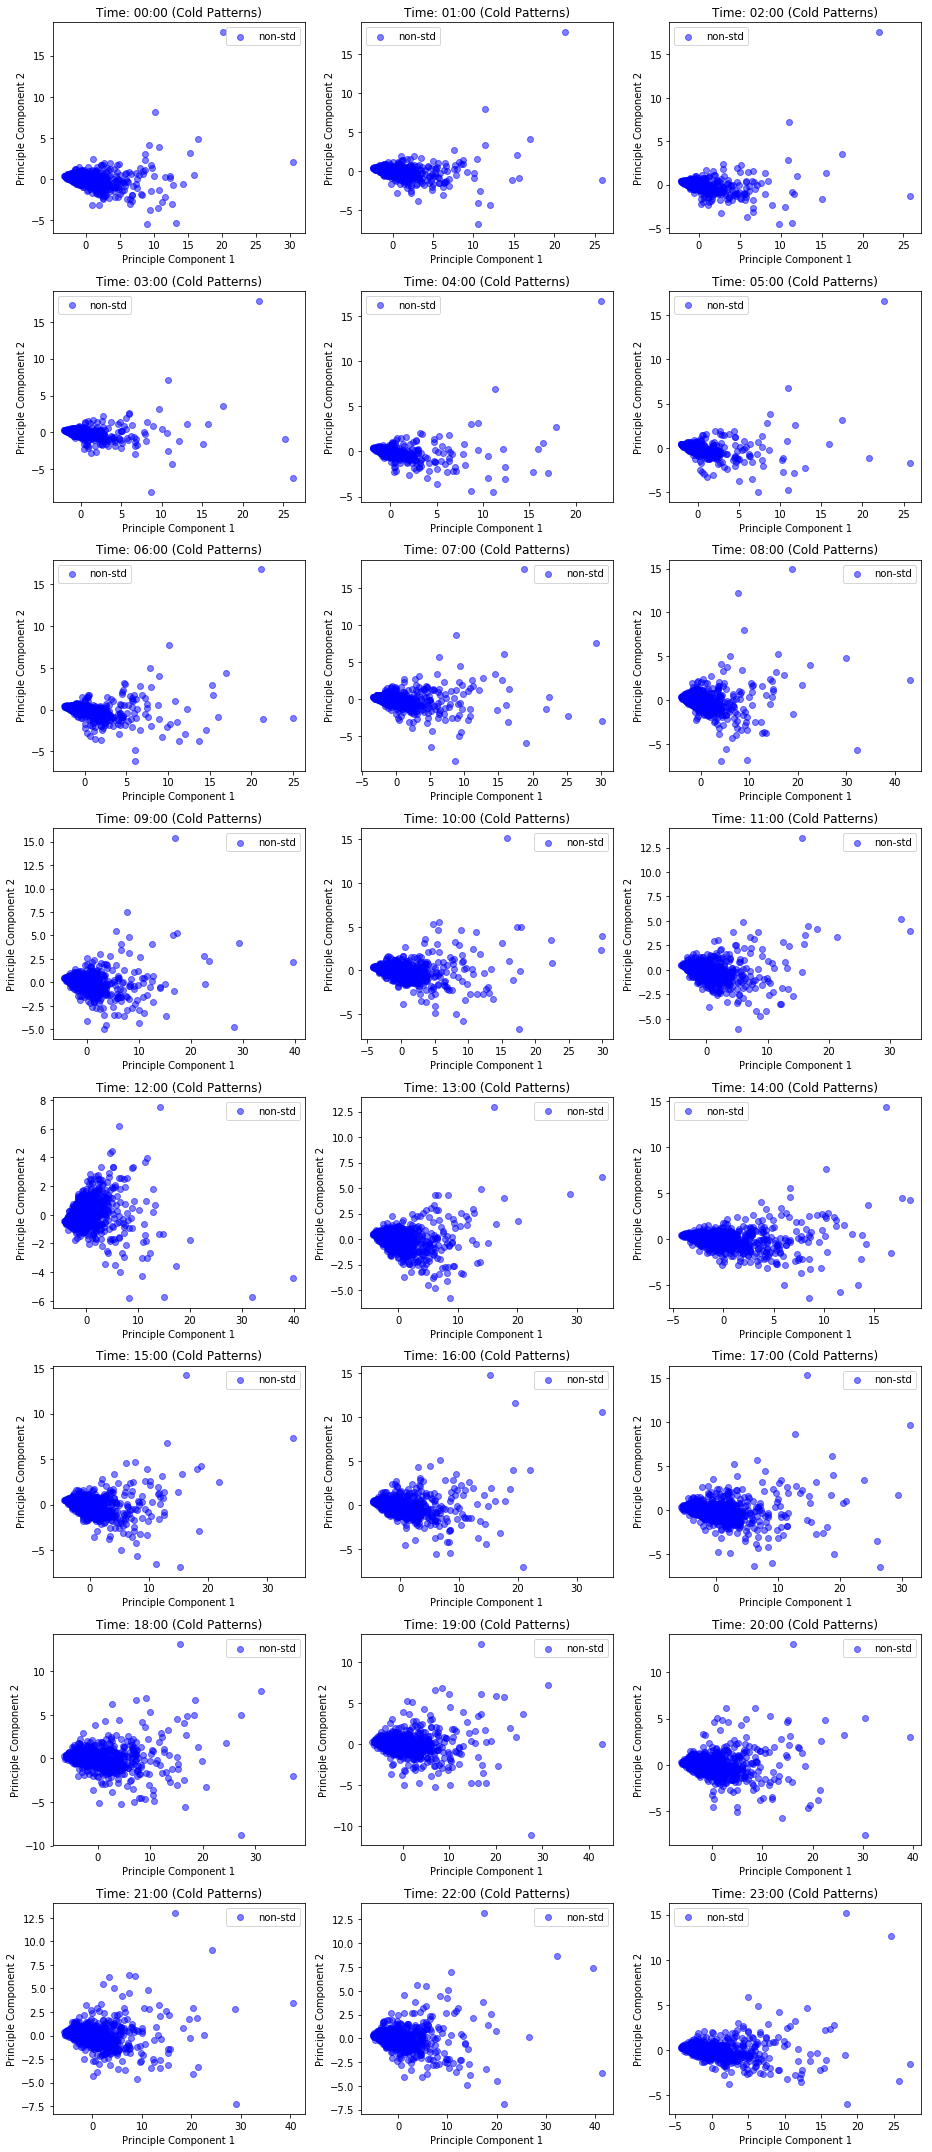

In [250]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

fig_all = plt.figure(figsize = (13,30))
for i in range(24):
    ax = fig_all.add_subplot(8, 3, i + 1)
    if i <= 9:
        x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains('0' + str(i) + ':00:00')]
        x.set_index('GMT', inplace = True)
        x = x.transpose().dropna() # data for the specific hour, and filtering out null value
        # PCA without standardization
        pca_nstd = PCA()
        principleComponents_nstd = pca_nstd.fit_transform(x)
        principleDf_nstd = pd.DataFrame(data = principleComponents_nstd)
        ax.scatter(principleDf_nstd[0], principleDf_nstd[1], c = 'blue', label = 'non-std', alpha = 0.5)
        # PCA with standardization
        x = x.values
        x = StandardScaler().fit_transform(x)
        pca = PCA()# keep all columns to cover 100% variance
        principleComponents = pca.fit_transform(x)
        principleDf = pd.DataFrame(data = principleComponents)
#         ax.scatter(principleDf[0], principleDf[1], c = 'red', label = 'std', alpha = 0.1)
        ax.set_title('Time: 0' + str(i) + ':00' + ' (Cold Patterns)')
        ax.legend()
        ax.set_xlabel('Principle Component 1')
        ax.set_ylabel('Principle Component 2')
    else:
        x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains(str(i) + ':00:00')]
        x.set_index('GMT', inplace = True)
        x = x.transpose().dropna() # data for the specific hour, and filtering out null value
        # PCA without standardization
        pca_nstd = PCA()
        principleComponents_nstd = pca_nstd.fit_transform(x)
        principleDf_nstd = pd.DataFrame(data = principleComponents_nstd)
        ax.scatter(principleDf_nstd[0], principleDf_nstd[1], c = 'blue', label = 'non-std', alpha = 0.5)
        # PCA with standardization
        x = x.values
        x = StandardScaler().fit_transform(x)
        pca = PCA()# keep all columns to cover 100% variance
        principleComponents = pca.fit_transform(x)
        principleDf = pd.DataFrame(data = principleComponents)
#         ax.scatter(principleDf[0], principleDf[1], c = 'red', label = 'std', alpha = 0.1)
        ax.set_title('Time: ' + str(i) + ':00' + ' (Cold Patterns)')
        ax.legend()
        ax.set_xlabel('Principle Component 1')
        ax.set_ylabel('Principle Component 2')
plt.tight_layout()

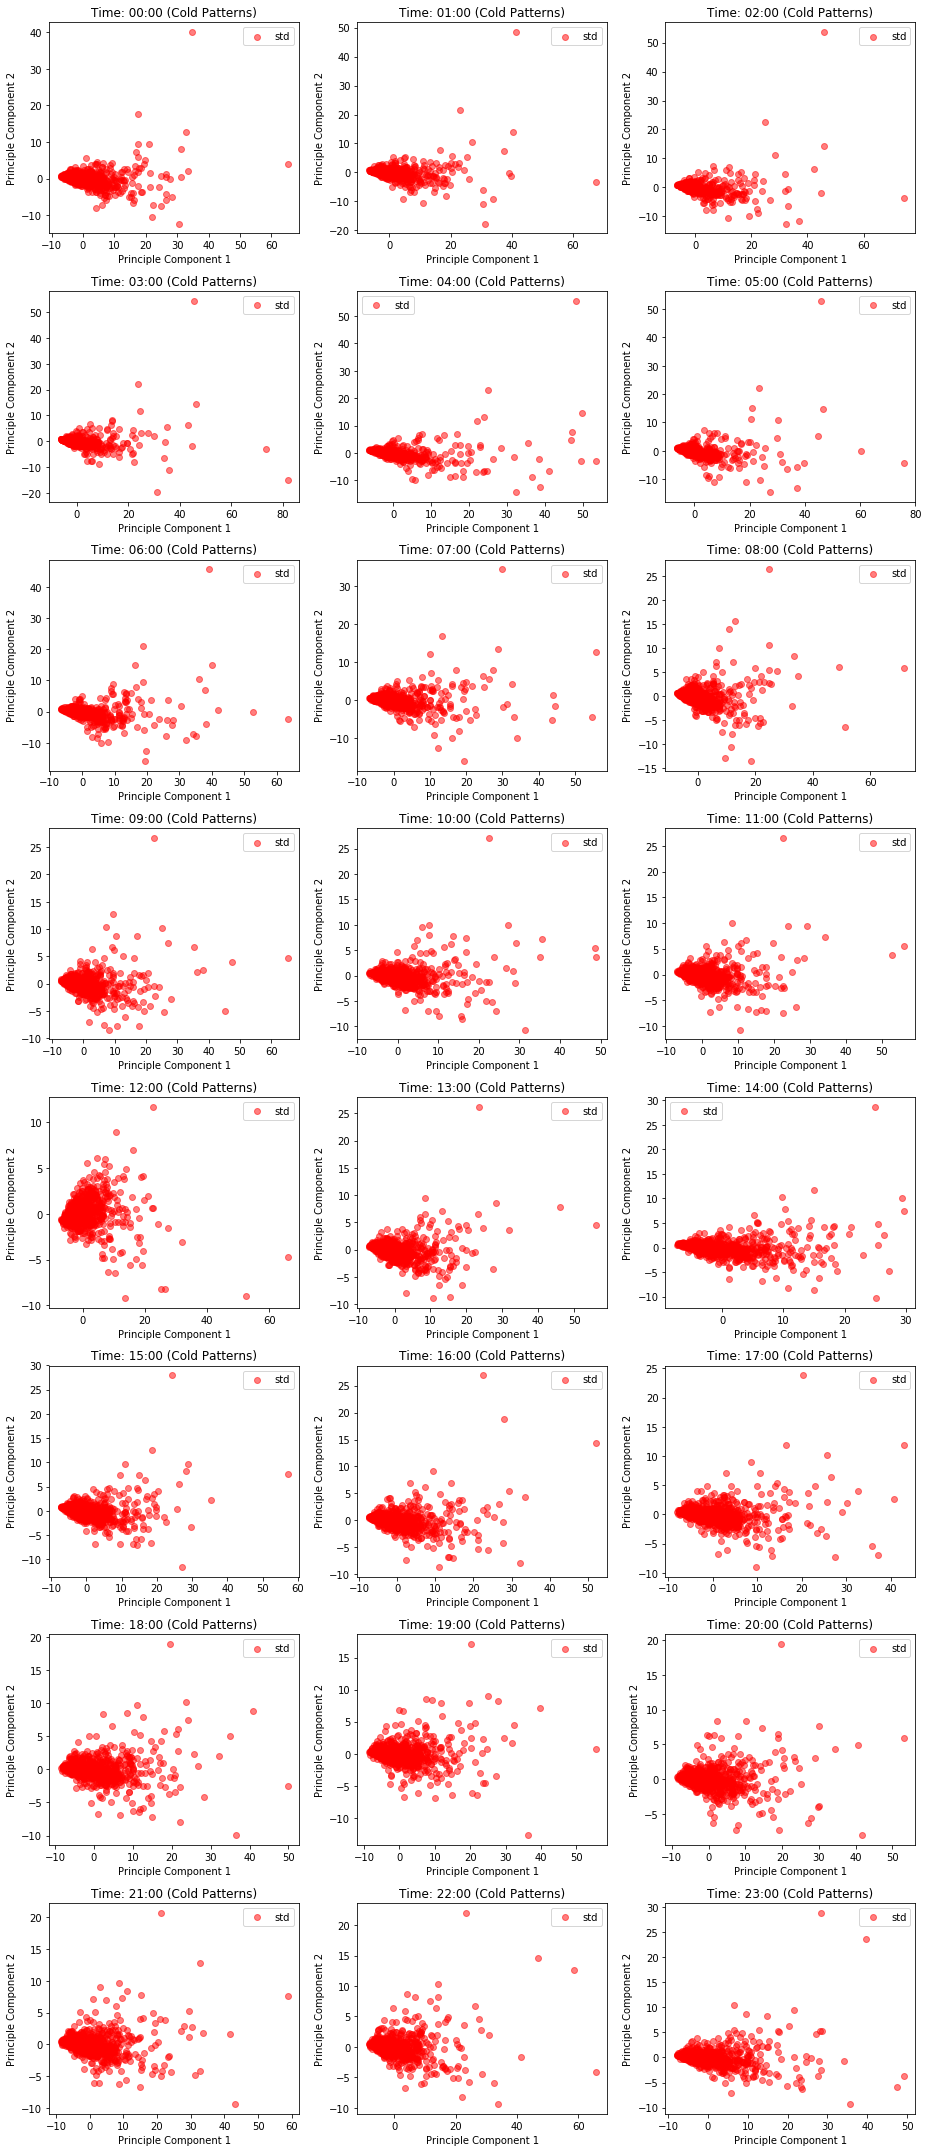

In [253]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

fig_all = plt.figure(figsize = (13,30))
for i in range(24):
    ax = fig_all.add_subplot(8, 3, i + 1)
    if i <= 9:
        x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains('0' + str(i) + ':00:00')]
        x.set_index('GMT', inplace = True)
        x = x.transpose().dropna() # data for the specific hour, and filtering out null value
        # PCA without standardization
        pca_nstd = PCA()
        principleComponents_nstd = pca_nstd.fit_transform(x)
        principleDf_nstd = pd.DataFrame(data = principleComponents_nstd)
#         ax.scatter(principleDf_nstd[0], principleDf_nstd[1], c = 'blue', label = 'non-std', alpha = 0.5)
        # PCA with standardization
        x = x.values
        x = StandardScaler().fit_transform(x)
        pca = PCA()# keep all columns to cover 100% variance
        principleComponents = pca.fit_transform(x)
        principleDf = pd.DataFrame(data = principleComponents)
        ax.scatter(principleDf[0], principleDf[1], c = 'red', label = 'std', alpha = 0.5)
        ax.set_title('Time: 0' + str(i) + ':00' + ' (Cold Patterns)')
        ax.legend()
        ax.set_xlabel('Principle Component 1')
        ax.set_ylabel('Principle Component 2')
    else:
        x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains(str(i) + ':00:00')]
        x.set_index('GMT', inplace = True)
        x = x.transpose().dropna() # data for the specific hour, and filtering out null value
        # PCA without standardization
        pca_nstd = PCA()
        principleComponents_nstd = pca_nstd.fit_transform(x)
        principleDf_nstd = pd.DataFrame(data = principleComponents_nstd)
#         ax.scatter(principleDf_nstd[0], principleDf_nstd[1], c = 'blue', label = 'non-std', alpha = 0.5)
        # PCA with standardization
        x = x.values
        x = StandardScaler().fit_transform(x)
        pca = PCA()# keep all columns to cover 100% variance
        principleComponents = pca.fit_transform(x)
        principleDf = pd.DataFrame(data = principleComponents)
        ax.scatter(principleDf[0], principleDf[1], c = 'red', label = 'std', alpha = 0.5)
        ax.set_title('Time: ' + str(i) + ':00' + ' (Cold Patterns)')
        ax.legend()
        ax.set_xlabel('Principle Component 1')
        ax.set_ylabel('Principle Component 2')
plt.tight_layout()

Different from the size-and-variable both standardization in paper 2, we care about the size effect. So we do not perform size standardization. Also in paper2, the author worried about the correlated problems, which wouldn't appear if they didn't use the no-size-scaled PCA to perform K-mean clustering. So the reason that problem seems to exist is they used the different PCA as the input of K-mean clustering and get the different labels, then put these labels to the previous PCA method, it seems that in Fig2 of their paper, each "category" seems has PC1 and PC2 linearly correlated, but this problem shouldn't have.

Component 1 and Component 3 relationship is shown below

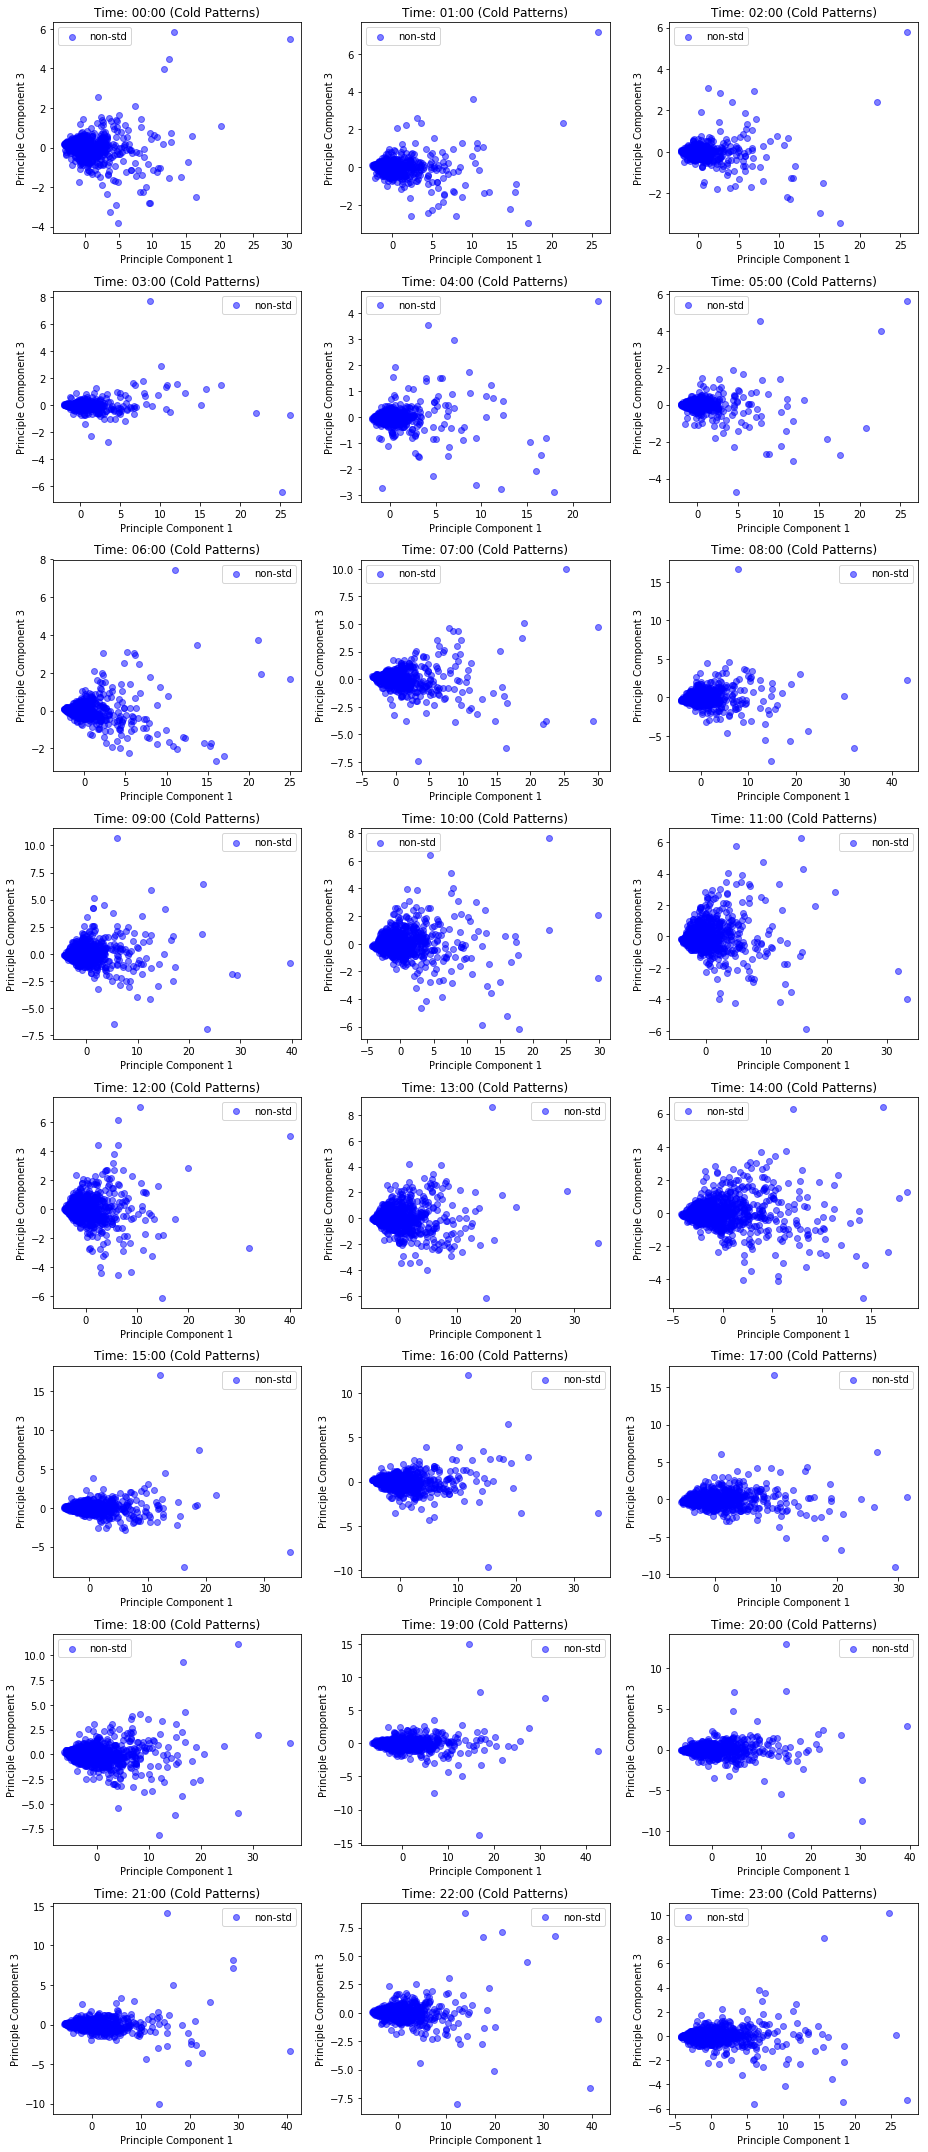

In [254]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

fig_all = plt.figure(figsize = (13,30))
for i in range(24):
    ax = fig_all.add_subplot(8, 3, i + 1)
    if i <= 9:
        x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains('0' + str(i) + ':00:00')]
        x.set_index('GMT', inplace = True)
        x = x.transpose().dropna() # data for the specific hour, and filtering out null value
        # PCA without standardization
        pca_nstd = PCA()
        principleComponents_nstd = pca_nstd.fit_transform(x)
        principleDf_nstd = pd.DataFrame(data = principleComponents_nstd)
        ax.scatter(principleDf_nstd[0], principleDf_nstd[2], c = 'blue', label = 'non-std', alpha = 0.5)
        # PCA with standardization
        x = x.values
        x = StandardScaler().fit_transform(x)
        pca = PCA()# keep all columns to cover 100% variance
        principleComponents = pca.fit_transform(x)
        principleDf = pd.DataFrame(data = principleComponents)
#         ax.scatter(principleDf[0], principleDf[2], c = 'red', label = 'std', alpha = 0.1)
        ax.set_title('Time: 0' + str(i) + ':00' + ' (Cold Patterns)')
        ax.legend()
        ax.set_xlabel('Principle Component 1')
        ax.set_ylabel('Principle Component 3')
    else:
        x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains(str(i) + ':00:00')]
        x.set_index('GMT', inplace = True)
        x = x.transpose().dropna() # data for the specific hour, and filtering out null value
        # PCA without standardization
        pca_nstd = PCA()
        principleComponents_nstd = pca_nstd.fit_transform(x)
        principleDf_nstd = pd.DataFrame(data = principleComponents_nstd)
        ax.scatter(principleDf_nstd[0], principleDf_nstd[2], c = 'blue', label = 'non-std', alpha = 0.5)
        # PCA with standardization
        x = x.values
        x = StandardScaler().fit_transform(x)
        pca = PCA()# keep all columns to cover 100% variance
        principleComponents = pca.fit_transform(x)
        principleDf = pd.DataFrame(data = principleComponents)
#         ax.scatter(principleDf[0], principleDf[2], c = 'red', label = 'std', alpha = 0.1)
        ax.set_title('Time: ' + str(i) + ':00' + ' (Cold Patterns)')
        ax.legend()
        ax.set_xlabel('Principle Component 1')
        ax.set_ylabel('Principle Component 3')
plt.tight_layout()

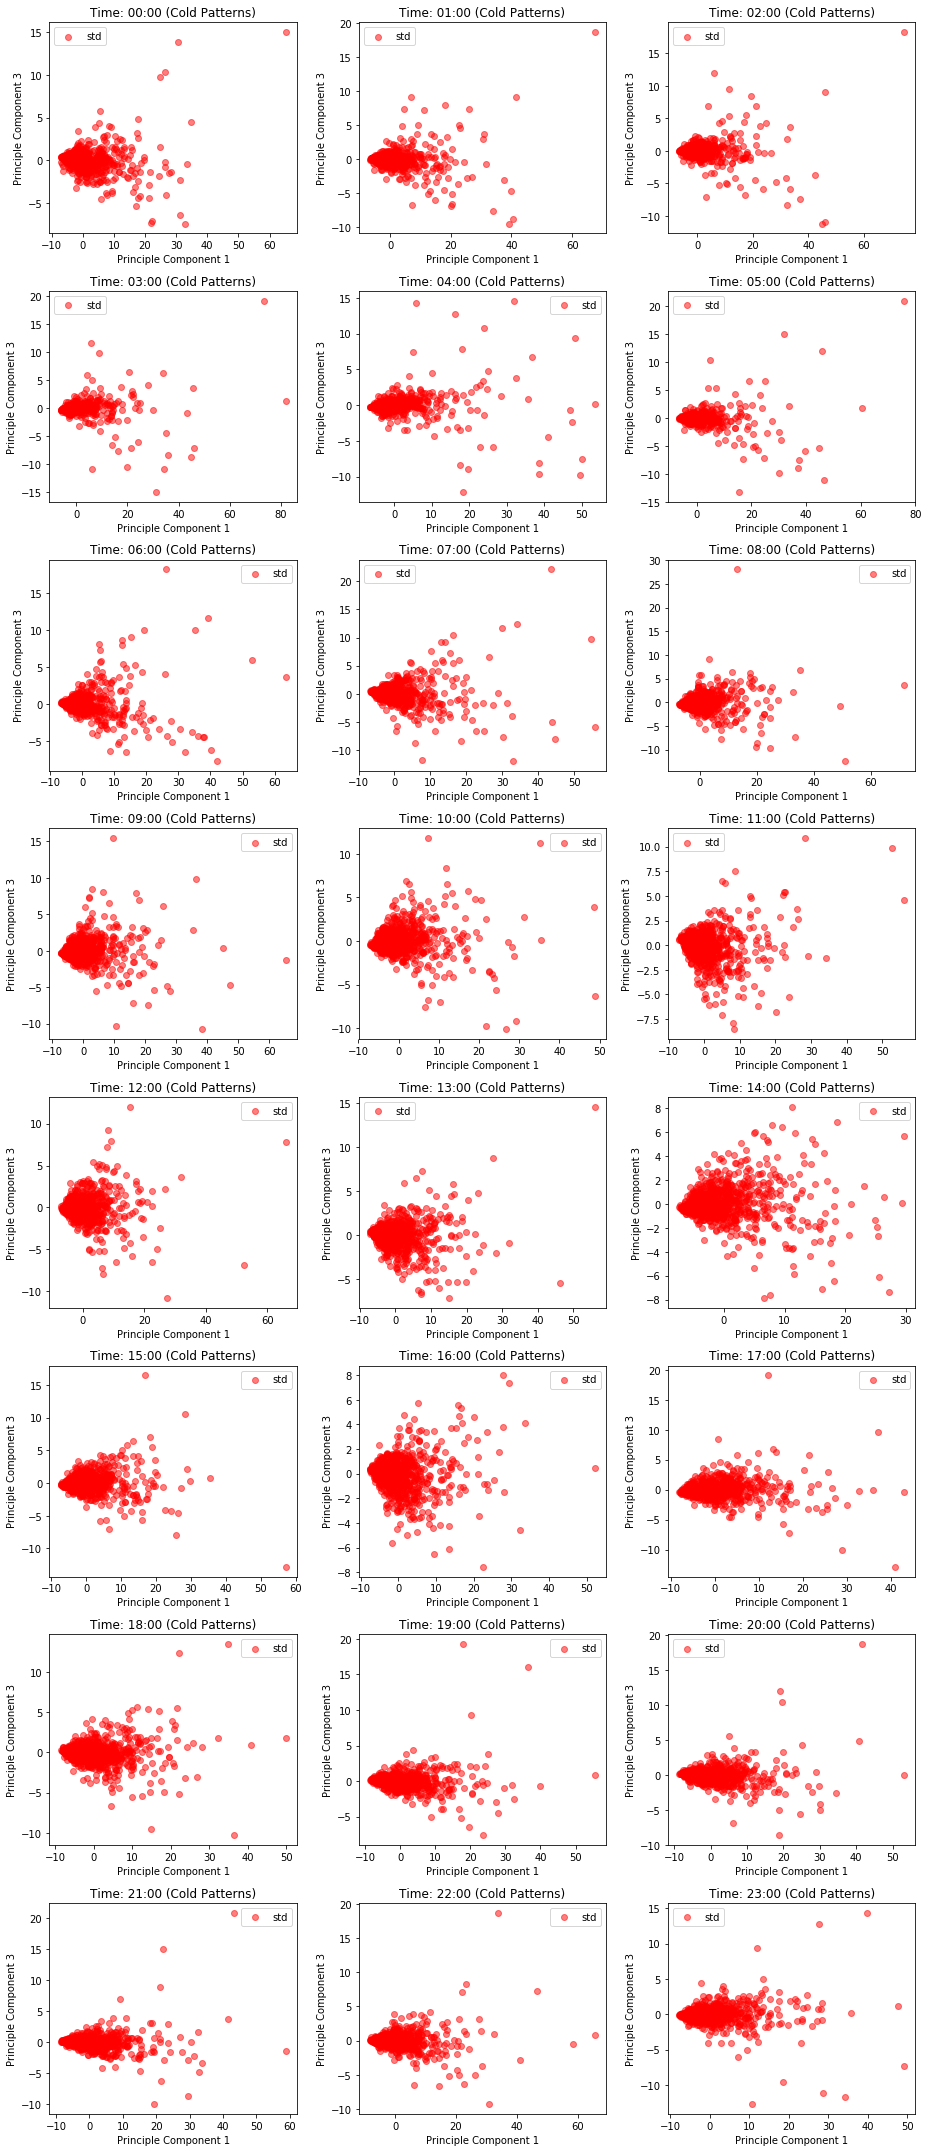

In [256]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

fig_all = plt.figure(figsize = (13,30))
for i in range(24):
    ax = fig_all.add_subplot(8, 3, i + 1)
    if i <= 9:
        x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains('0' + str(i) + ':00:00')]
        x.set_index('GMT', inplace = True)
        x = x.transpose().dropna() # data for the specific hour, and filtering out null value
        # PCA without standardization
        pca_nstd = PCA()
        principleComponents_nstd = pca_nstd.fit_transform(x)
        principleDf_nstd = pd.DataFrame(data = principleComponents_nstd)
#         ax.scatter(principleDf_nstd[0], principleDf_nstd[2], c = 'blue', label = 'non-std', alpha = 0.5)
        # PCA with standardization
        x = x.values
        x = StandardScaler().fit_transform(x)
        pca = PCA()# keep all columns to cover 100% variance
        principleComponents = pca.fit_transform(x)
        principleDf = pd.DataFrame(data = principleComponents)
        ax.scatter(principleDf[0], principleDf[2], c = 'red', label = 'std', alpha = 0.5)
        ax.set_title('Time: 0' + str(i) + ':00' + ' (Cold Patterns)')
        ax.legend()
        ax.set_xlabel('Principle Component 1')
        ax.set_ylabel('Principle Component 3')
    else:
        x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains(str(i) + ':00:00')]
        x.set_index('GMT', inplace = True)
        x = x.transpose().dropna() # data for the specific hour, and filtering out null value
        # PCA without standardization
        pca_nstd = PCA()
        principleComponents_nstd = pca_nstd.fit_transform(x)
        principleDf_nstd = pd.DataFrame(data = principleComponents_nstd)
#         ax.scatter(principleDf_nstd[0], principleDf_nstd[2], c = 'blue', label = 'non-std', alpha = 0.5)
        # PCA with standardization
        x = x.values
        x = StandardScaler().fit_transform(x)
        pca = PCA()# keep all columns to cover 100% variance
        principleComponents = pca.fit_transform(x)
        principleDf = pd.DataFrame(data = principleComponents)
        ax.scatter(principleDf[0], principleDf[2], c = 'red', label = 'std', alpha = 0.5)
        ax.set_title('Time: ' + str(i) + ':00' + ' (Cold Patterns)')
        ax.legend()
        ax.set_xlabel('Principle Component 1')
        ax.set_ylabel('Principle Component 3')
plt.tight_layout()

Component 2 and Component 3 relationship is shown below

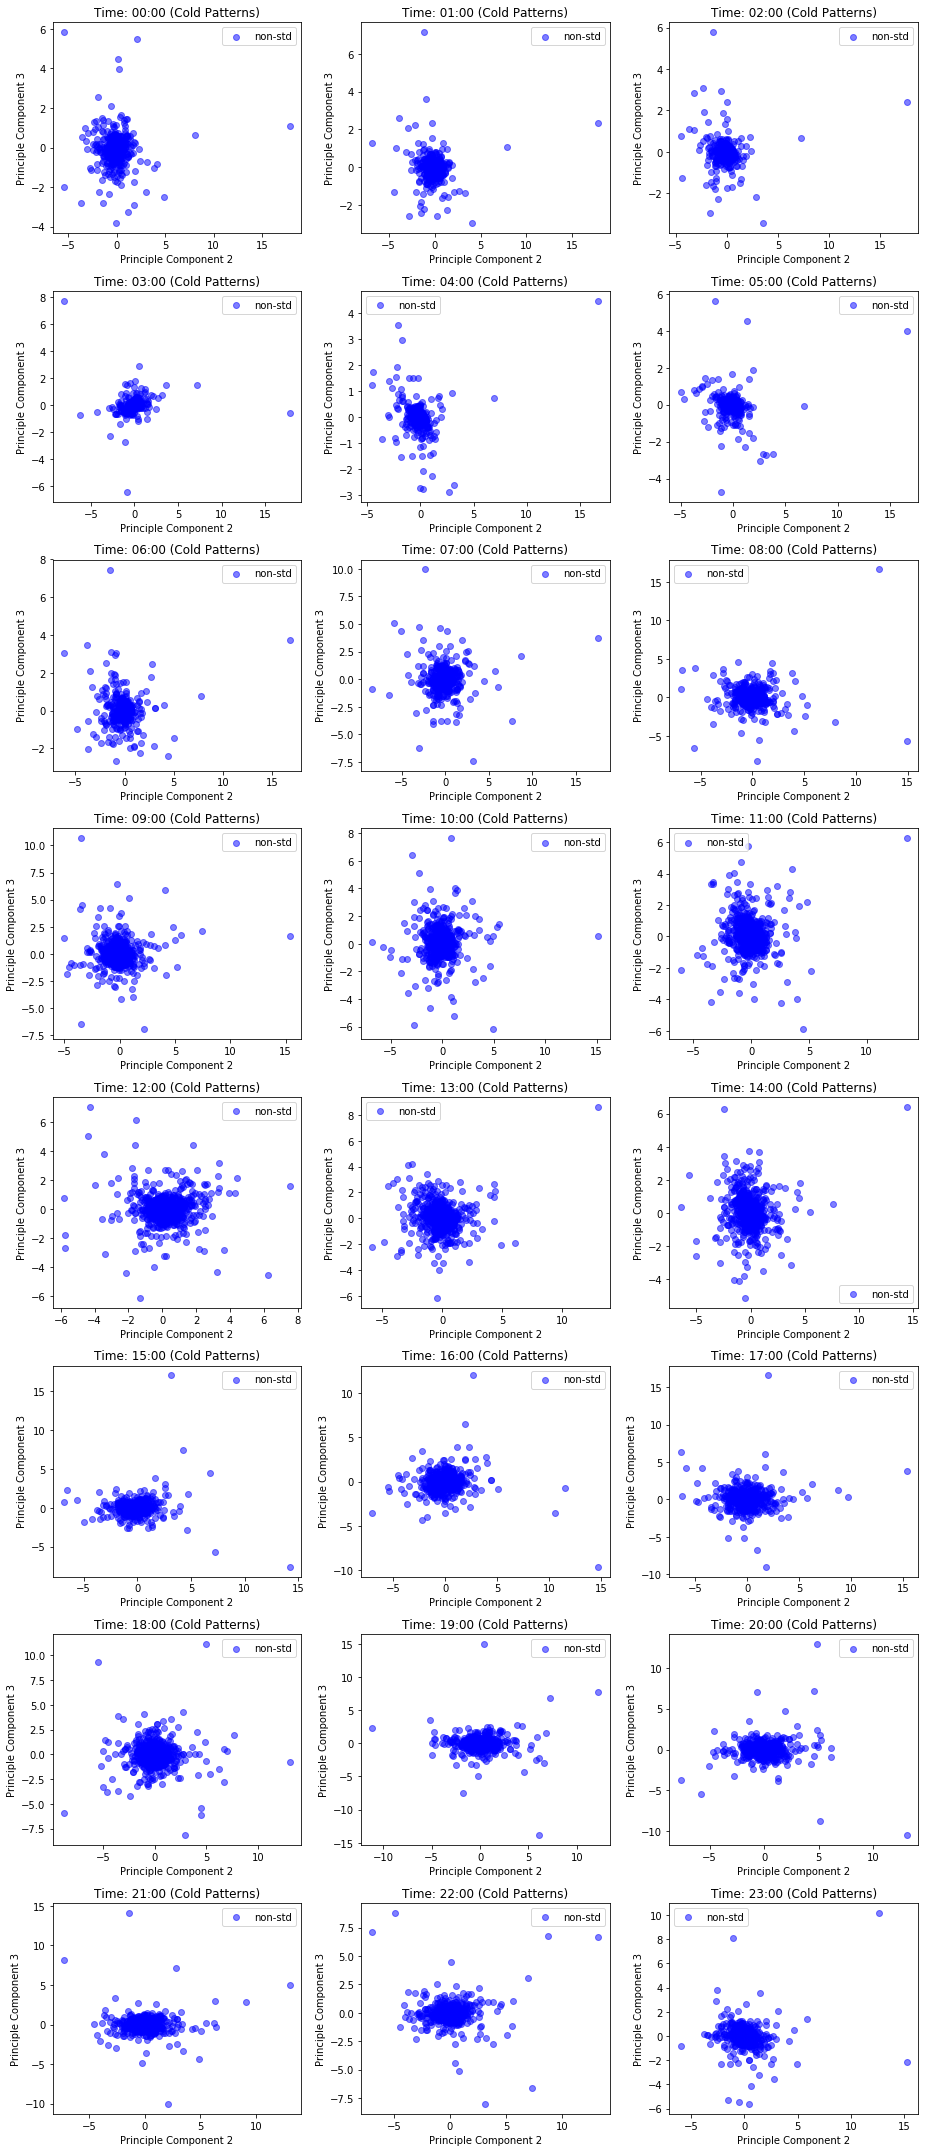

In [257]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

fig_all = plt.figure(figsize = (13,30))
for i in range(24):
    ax = fig_all.add_subplot(8, 3, i + 1)
    if i <= 9:
        x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains('0' + str(i) + ':00:00')]
        x.set_index('GMT', inplace = True)
        x = x.transpose().dropna() # data for the specific hour, and filtering out null value
        # PCA without standardization
        pca_nstd = PCA()
        principleComponents_nstd = pca_nstd.fit_transform(x)
        principleDf_nstd = pd.DataFrame(data = principleComponents_nstd)
        ax.scatter(principleDf_nstd[1], principleDf_nstd[2], c = 'blue', label = 'non-std', alpha = 0.5)
        # PCA with standardization
        x = x.values
        x = StandardScaler().fit_transform(x)
        pca = PCA()# keep all columns to cover 100% variance
        principleComponents = pca.fit_transform(x)
        principleDf = pd.DataFrame(data = principleComponents)
#         ax.scatter(principleDf[1], principleDf[2], c = 'red', label = 'std', alpha = 0.5)
        ax.set_title('Time: 0' + str(i) + ':00' + ' (Cold Patterns)')
        ax.legend()
        ax.set_xlabel('Principle Component 2')
        ax.set_ylabel('Principle Component 3')
    else:
        x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains(str(i) + ':00:00')]
        x.set_index('GMT', inplace = True)
        x = x.transpose().dropna() # data for the specific hour, and filtering out null value
        # PCA without standardization
        pca_nstd = PCA()
        principleComponents_nstd = pca_nstd.fit_transform(x)
        principleDf_nstd = pd.DataFrame(data = principleComponents_nstd)
        ax.scatter(principleDf_nstd[1], principleDf_nstd[2], c = 'blue', label = 'non-std', alpha = 0.5)
        # PCA with standardization
        x = x.values
        x = StandardScaler().fit_transform(x)
        pca = PCA()# keep all columns to cover 100% variance
        principleComponents = pca.fit_transform(x)
        principleDf = pd.DataFrame(data = principleComponents)
#         ax.scatter(principleDf[1], principleDf[2], c = 'red', label = 'std', alpha = 0.5)
        ax.set_title('Time: ' + str(i) + ':00' + ' (Cold Patterns)')
        ax.legend()
        ax.set_xlabel('Principle Component 2')
        ax.set_ylabel('Principle Component 3')
plt.tight_layout()

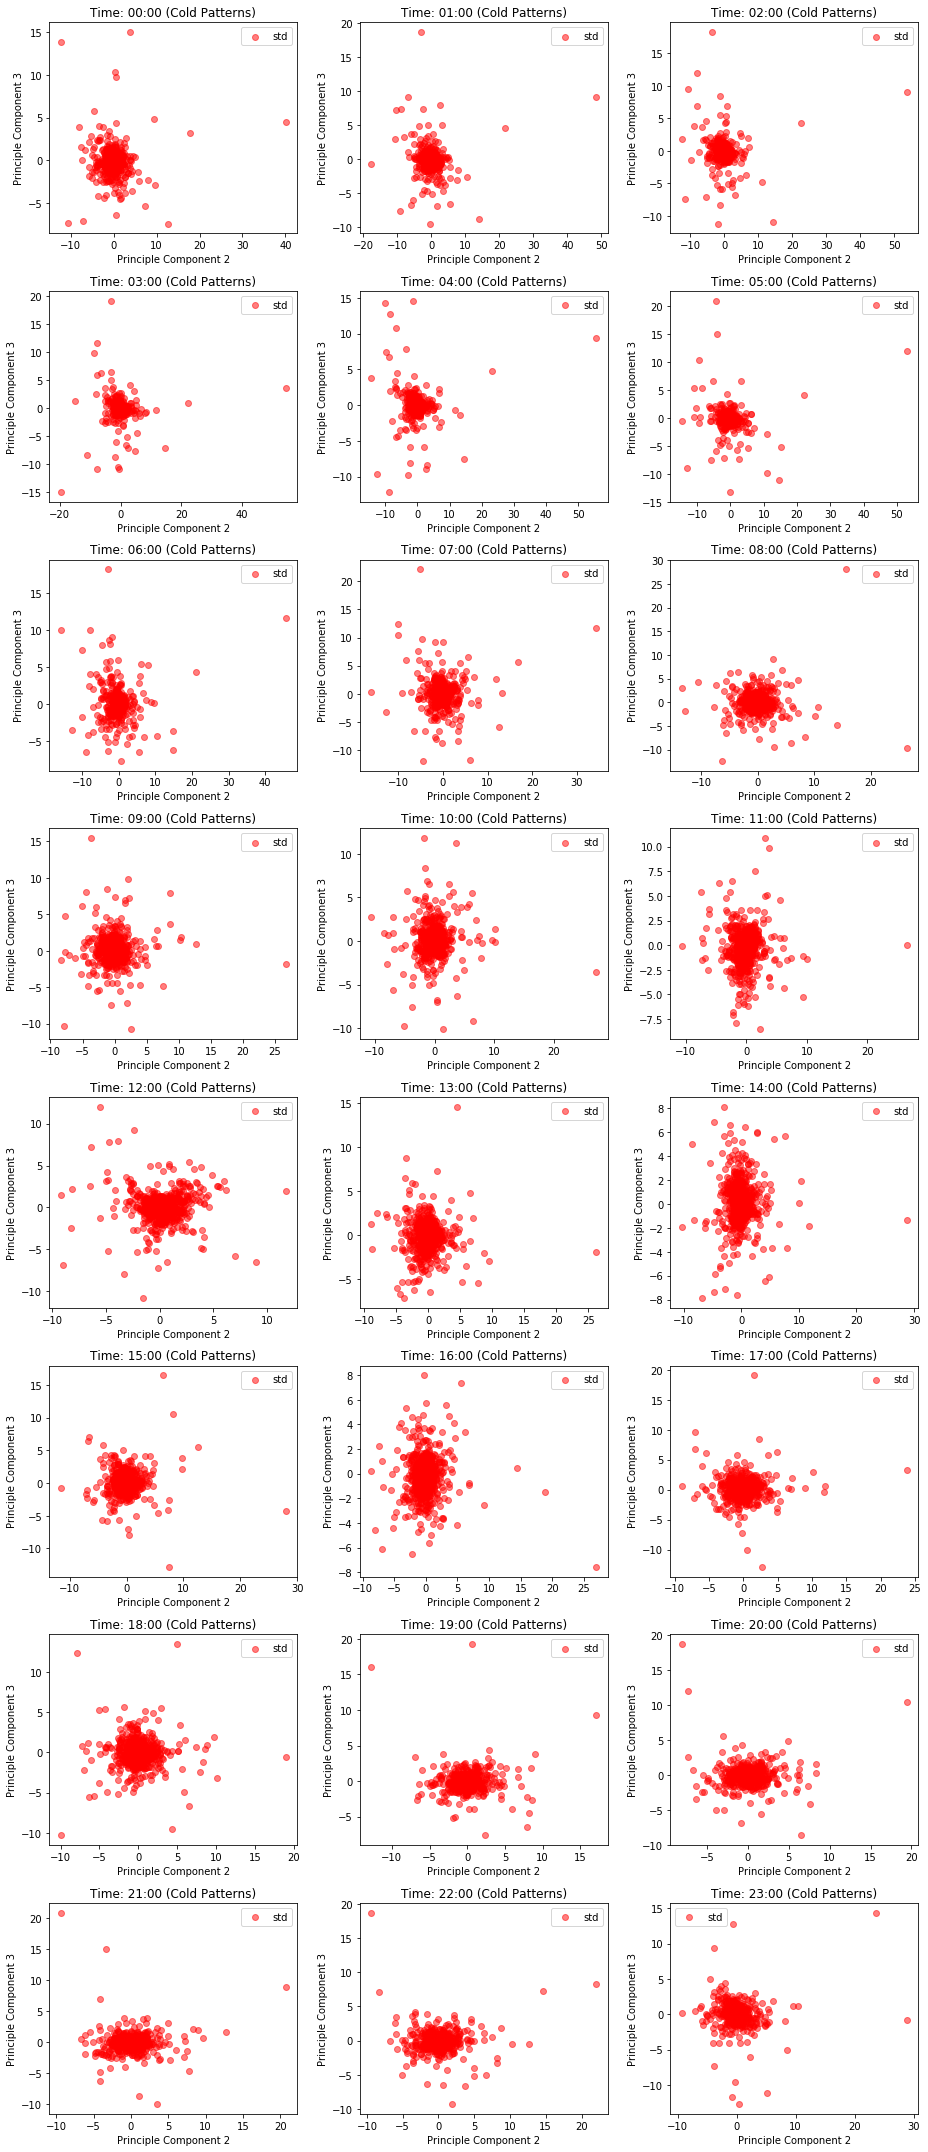

In [258]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

fig_all = plt.figure(figsize = (13,30))
for i in range(24):
    ax = fig_all.add_subplot(8, 3, i + 1)
    if i <= 9:
        x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains('0' + str(i) + ':00:00')]
        x.set_index('GMT', inplace = True)
        x = x.transpose().dropna() # data for the specific hour, and filtering out null value
        # PCA without standardization
        pca_nstd = PCA()
        principleComponents_nstd = pca_nstd.fit_transform(x)
        principleDf_nstd = pd.DataFrame(data = principleComponents_nstd)
#         ax.scatter(principleDf_nstd[1], principleDf_nstd[2], c = 'blue', label = 'non-std', alpha = 0.5)
        # PCA with standardization
        x = x.values
        x = StandardScaler().fit_transform(x)
        pca = PCA()# keep all columns to cover 100% variance
        principleComponents = pca.fit_transform(x)
        principleDf = pd.DataFrame(data = principleComponents)
        ax.scatter(principleDf[1], principleDf[2], c = 'red', label = 'std', alpha = 0.5)
        ax.set_title('Time: 0' + str(i) + ':00' + ' (Cold Patterns)')
        ax.legend()
        ax.set_xlabel('Principle Component 2')
        ax.set_ylabel('Principle Component 3')
    else:
        x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains(str(i) + ':00:00')]
        x.set_index('GMT', inplace = True)
        x = x.transpose().dropna() # data for the specific hour, and filtering out null value
        # PCA without standardization
        pca_nstd = PCA()
        principleComponents_nstd = pca_nstd.fit_transform(x)
        principleDf_nstd = pd.DataFrame(data = principleComponents_nstd)
#         ax.scatter(principleDf_nstd[1], principleDf_nstd[2], c = 'blue', label = 'non-std', alpha = 0.5)
        # PCA with standardization
        x = x.values
        x = StandardScaler().fit_transform(x)
        pca = PCA()# keep all columns to cover 100% variance
        principleComponents = pca.fit_transform(x)
        principleDf = pd.DataFrame(data = principleComponents)
        ax.scatter(principleDf[1], principleDf[2], c = 'red', label = 'std', alpha = 0.5)
        ax.set_title('Time: ' + str(i) + ':00' + ' (Cold Patterns)')
        ax.legend()
        ax.set_xlabel('Principle Component 2')
        ax.set_ylabel('Principle Component 3')
plt.tight_layout()

The above three types of plots show that std don't have significant advantage in this case, so we will use non-std in our later analysis.

Let's try to interprete PCs' meaning: 

(1) PC1's coefficients vs Temperature:

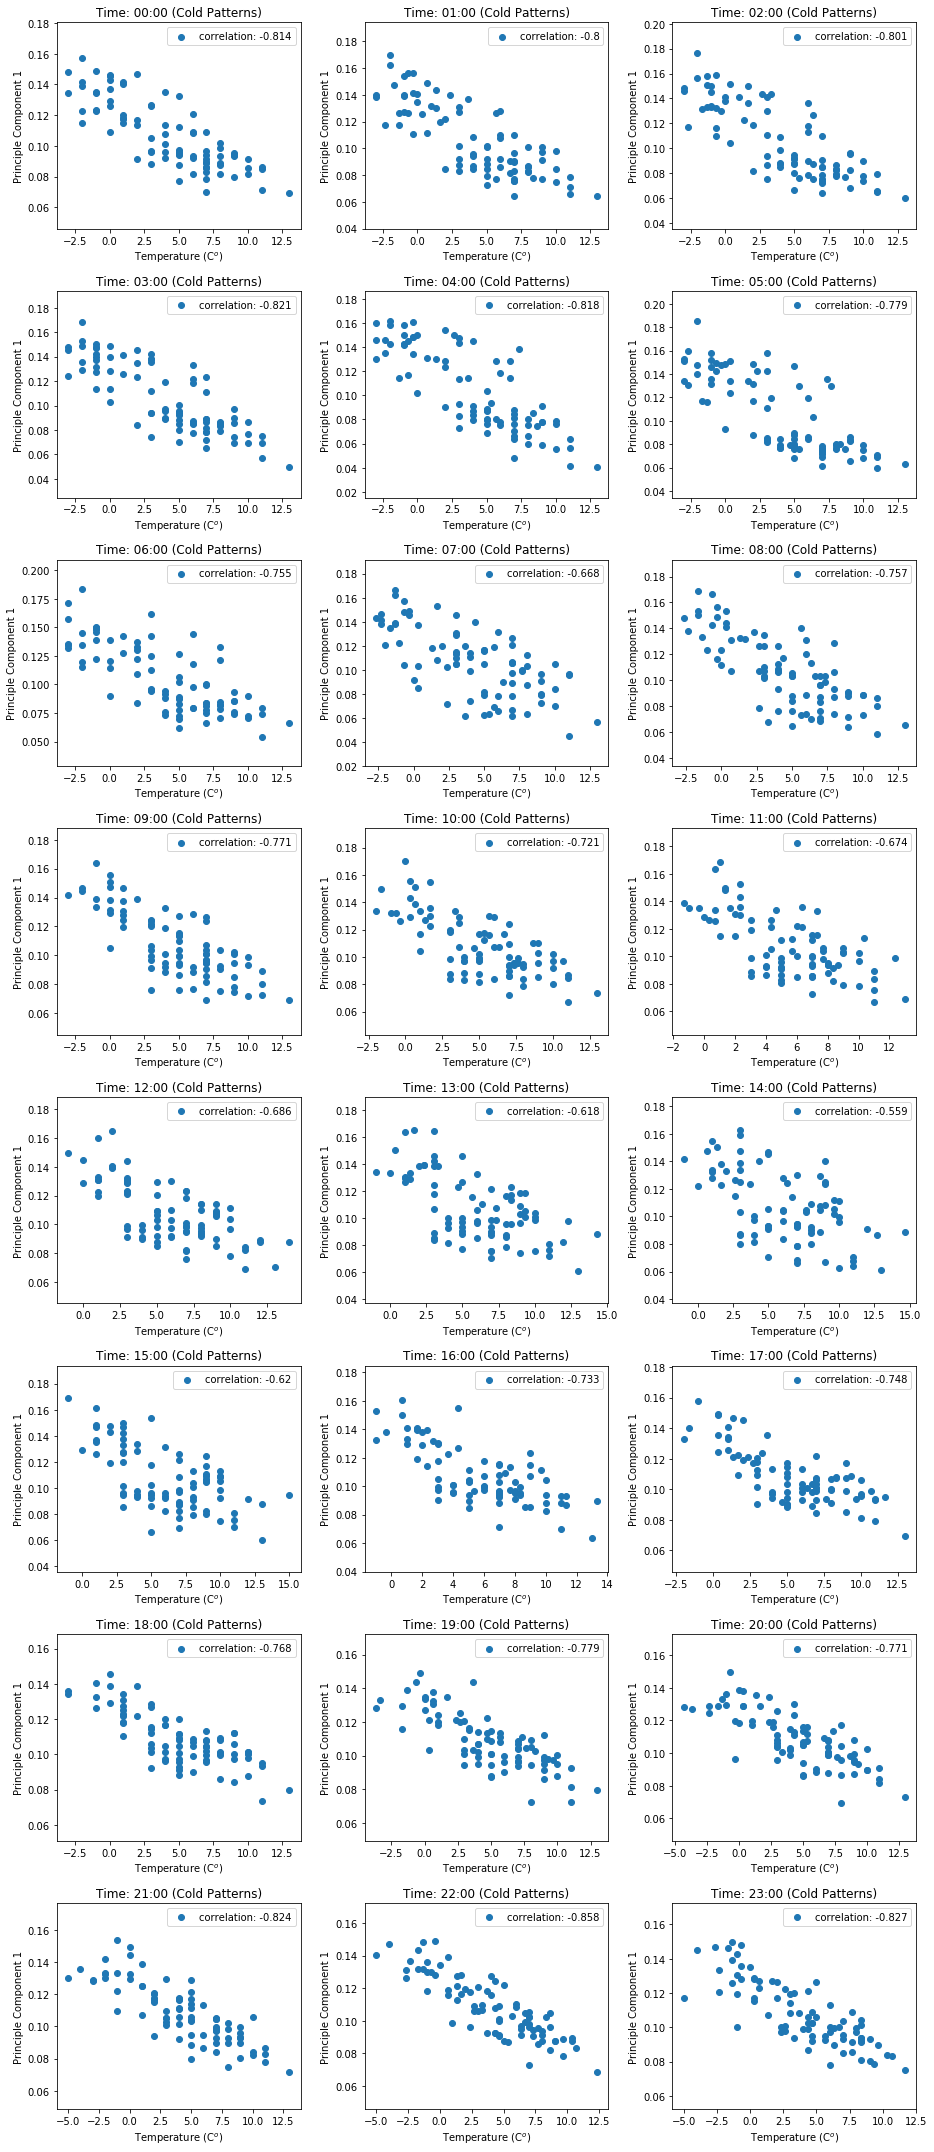

In [260]:
fig_all = plt.figure(figsize = (13,30))
for i in range(24):
    ax = fig_all.add_subplot(8, 3, i + 1)
    if i <= 9:
        x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains('0' + str(i) + ':00:00')]
        x.set_index('GMT', inplace = True)
        x = x.transpose().dropna() # data for the specific hour, and filtering out null value
        # PCA without standardization
        pca_nstd = PCA()
        principleComponents_nstd = pca_nstd.fit_transform(x)
        principleDf_nstd = pd.DataFrame(data = principleComponents_nstd)
        ax.scatter(df_wea1h_nf_cold.TempC[df_tou1h_nf_cold.GMT.str.contains('0' + str(i) + ':00:00')], pca_nstd.components_[0], label = 'correlation: ' + str(round(np.corrcoef(pca_nstd.components_[0], df_wea1h_nf_cold.TempC[df_tou1h_nf_cold.GMT.str.contains('0' + str(i) + ':00:00')])[0][1], 3)))
        ax.set_title('Time: 0' + str(i) + ':00' + ' (Cold Patterns)')
        ax.legend()
        ax.set_xlabel(r'Temperature (C$^o$)')
        ax.set_ylabel('Principle Component 1')
    else:
        x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains(str(i) + ':00:00')]
        x.set_index('GMT', inplace = True)
        x = x.transpose().dropna() # data for the specific hour, and filtering out null value
        # PCA without standardization
        pca_nstd = PCA()
        principleComponents_nstd = pca_nstd.fit_transform(x)
        principleDf_nstd = pd.DataFrame(data = principleComponents_nstd)
        ax.scatter(df_wea1h_nf_cold.TempC[df_tou1h_nf_cold.GMT.str.contains(str(i) + ':00:00')], pca_nstd.components_[0], label = 'correlation: ' + str(round(np.corrcoef(pca_nstd.components_[0], df_wea1h_nf_cold.TempC[df_tou1h_nf_cold.GMT.str.contains(str(i) + ':00:00')])[0][1], 3)))
        ax.set_title('Time: ' + str(i) + ':00' + ' (Cold Patterns)')
        ax.legend()
        ax.set_xlabel(r'Temperature (C$^o$)')
        ax.set_ylabel('Principle Component 1')
plt.tight_layout()

2) PC2's coefficients  vs Temperature:

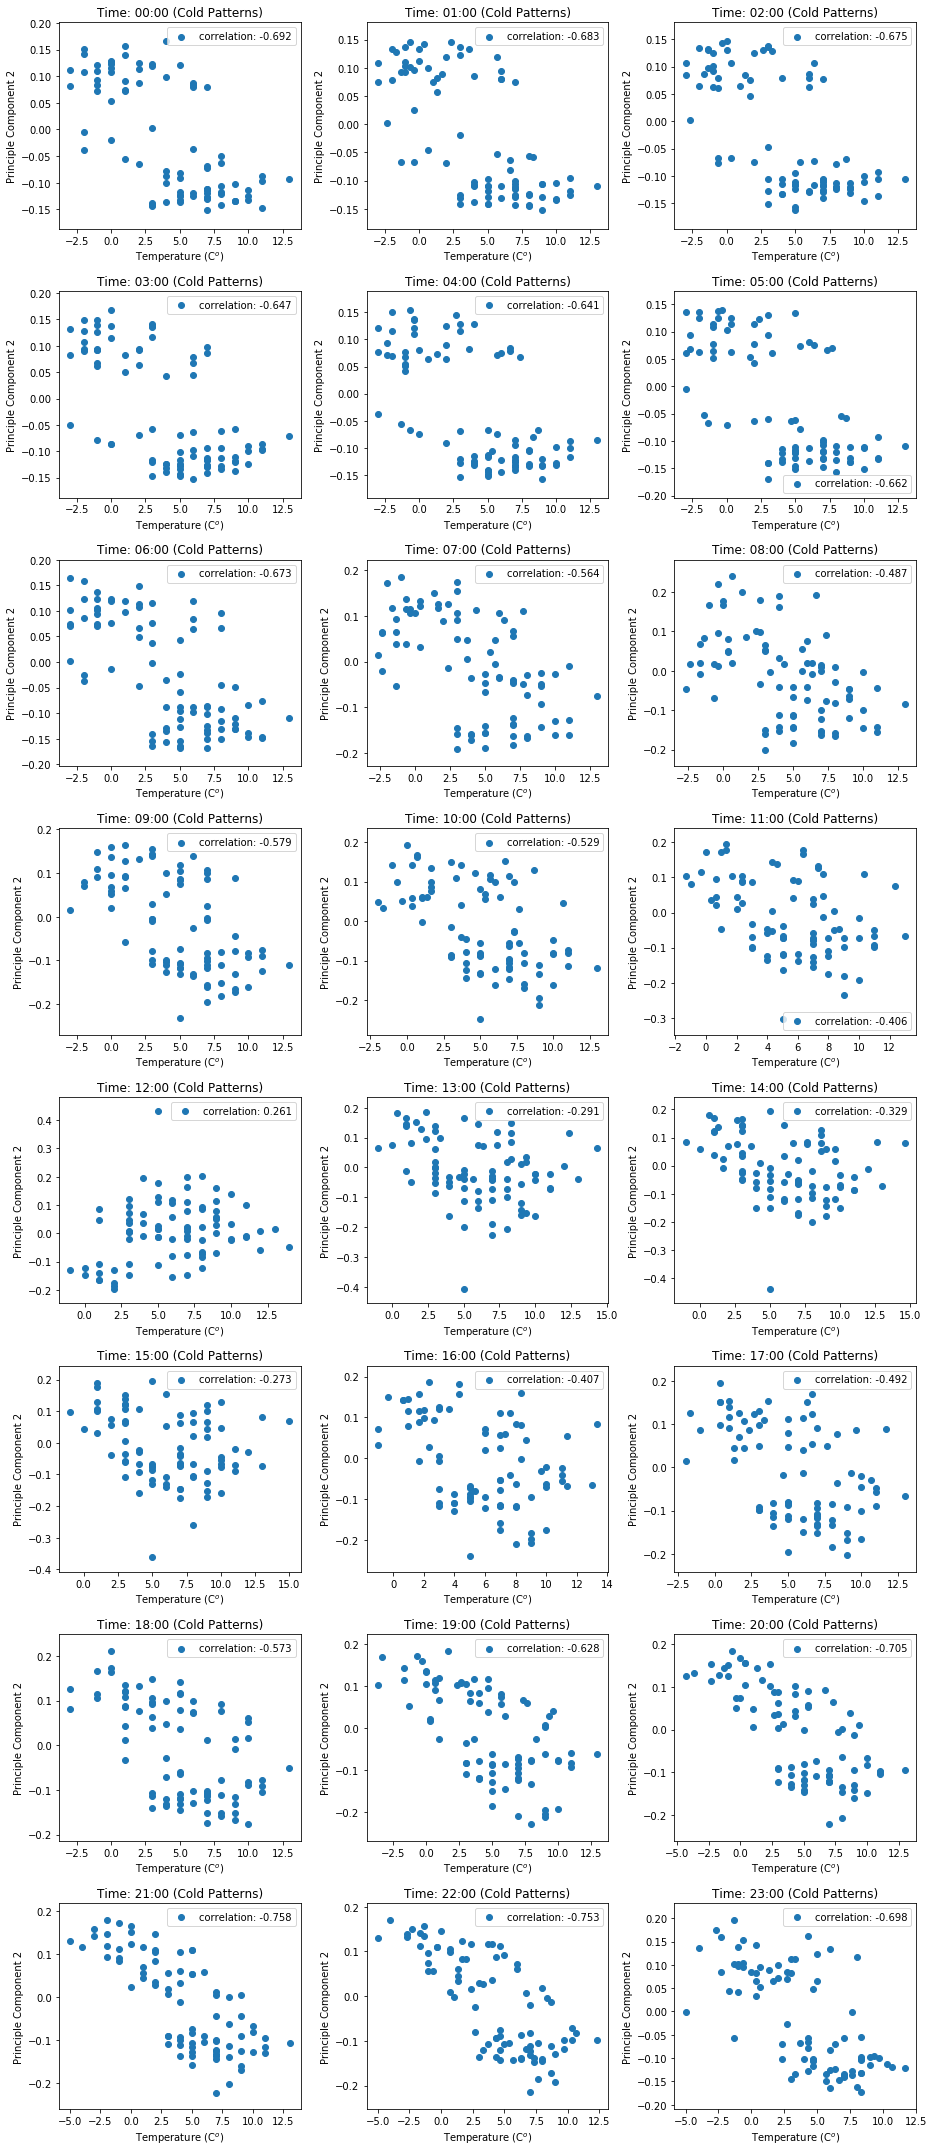

In [234]:
fig_all = plt.figure(figsize = (13,30))
for i in range(24):
    ax = fig_all.add_subplot(8, 3, i + 1)
    if i <= 9:
        x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains('0' + str(i) + ':00:00')]
        x.set_index('GMT', inplace = True)
        x = x.transpose().dropna() # data for the specific hour, and filtering out null value
        # PCA without standardization
        pca_nstd = PCA()
        principleComponents_nstd = pca_nstd.fit_transform(x)
        principleDf_nstd = pd.DataFrame(data = principleComponents_nstd)
        ax.scatter(df_wea1h_nf_cold.TempC[df_tou1h_nf_cold.GMT.str.contains('0' + str(i) + ':00:00')], pca_nstd.components_[1], label = 'correlation: ' + str(round(np.corrcoef(pca_nstd.components_[1], df_wea1h_nf_cold.TempC[df_tou1h_nf_cold.GMT.str.contains('0' + str(i) + ':00:00')])[0][1], 3)))
        ax.set_title('Time: 0' + str(i) + ':00' + ' (Cold Patterns)')
        ax.legend()
        ax.set_xlabel(r'Temperature (C$^o$)')
        ax.set_ylabel('Principle Component 2')
    else:
        x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains(str(i) + ':00:00')]
        x.set_index('GMT', inplace = True)
        x = x.transpose().dropna() # data for the specific hour, and filtering out null value
        # PCA without standardization
        pca_nstd = PCA()
        principleComponents_nstd = pca_nstd.fit_transform(x)
        principleDf_nstd = pd.DataFrame(data = principleComponents_nstd)
        ax.scatter(df_wea1h_nf_cold.TempC[df_tou1h_nf_cold.GMT.str.contains(str(i) + ':00:00')], pca_nstd.components_[1], label = 'correlation: ' + str(round(np.corrcoef(pca_nstd.components_[1], df_wea1h_nf_cold.TempC[df_tou1h_nf_cold.GMT.str.contains(str(i) + ':00:00')])[0][1], 3)))
        ax.set_title('Time: ' + str(i) + ':00' + ' (Cold Patterns)')
        ax.legend()
        ax.set_xlabel(r'Temperature (C$^o$)')
        ax.set_ylabel('Principle Component 2')
plt.tight_layout()

The above figures show that PC2 still has certain amount of correlation with temperature but not as significant as PC1 and temperature have.

3) PC3's coefficients vs Day of a Week:

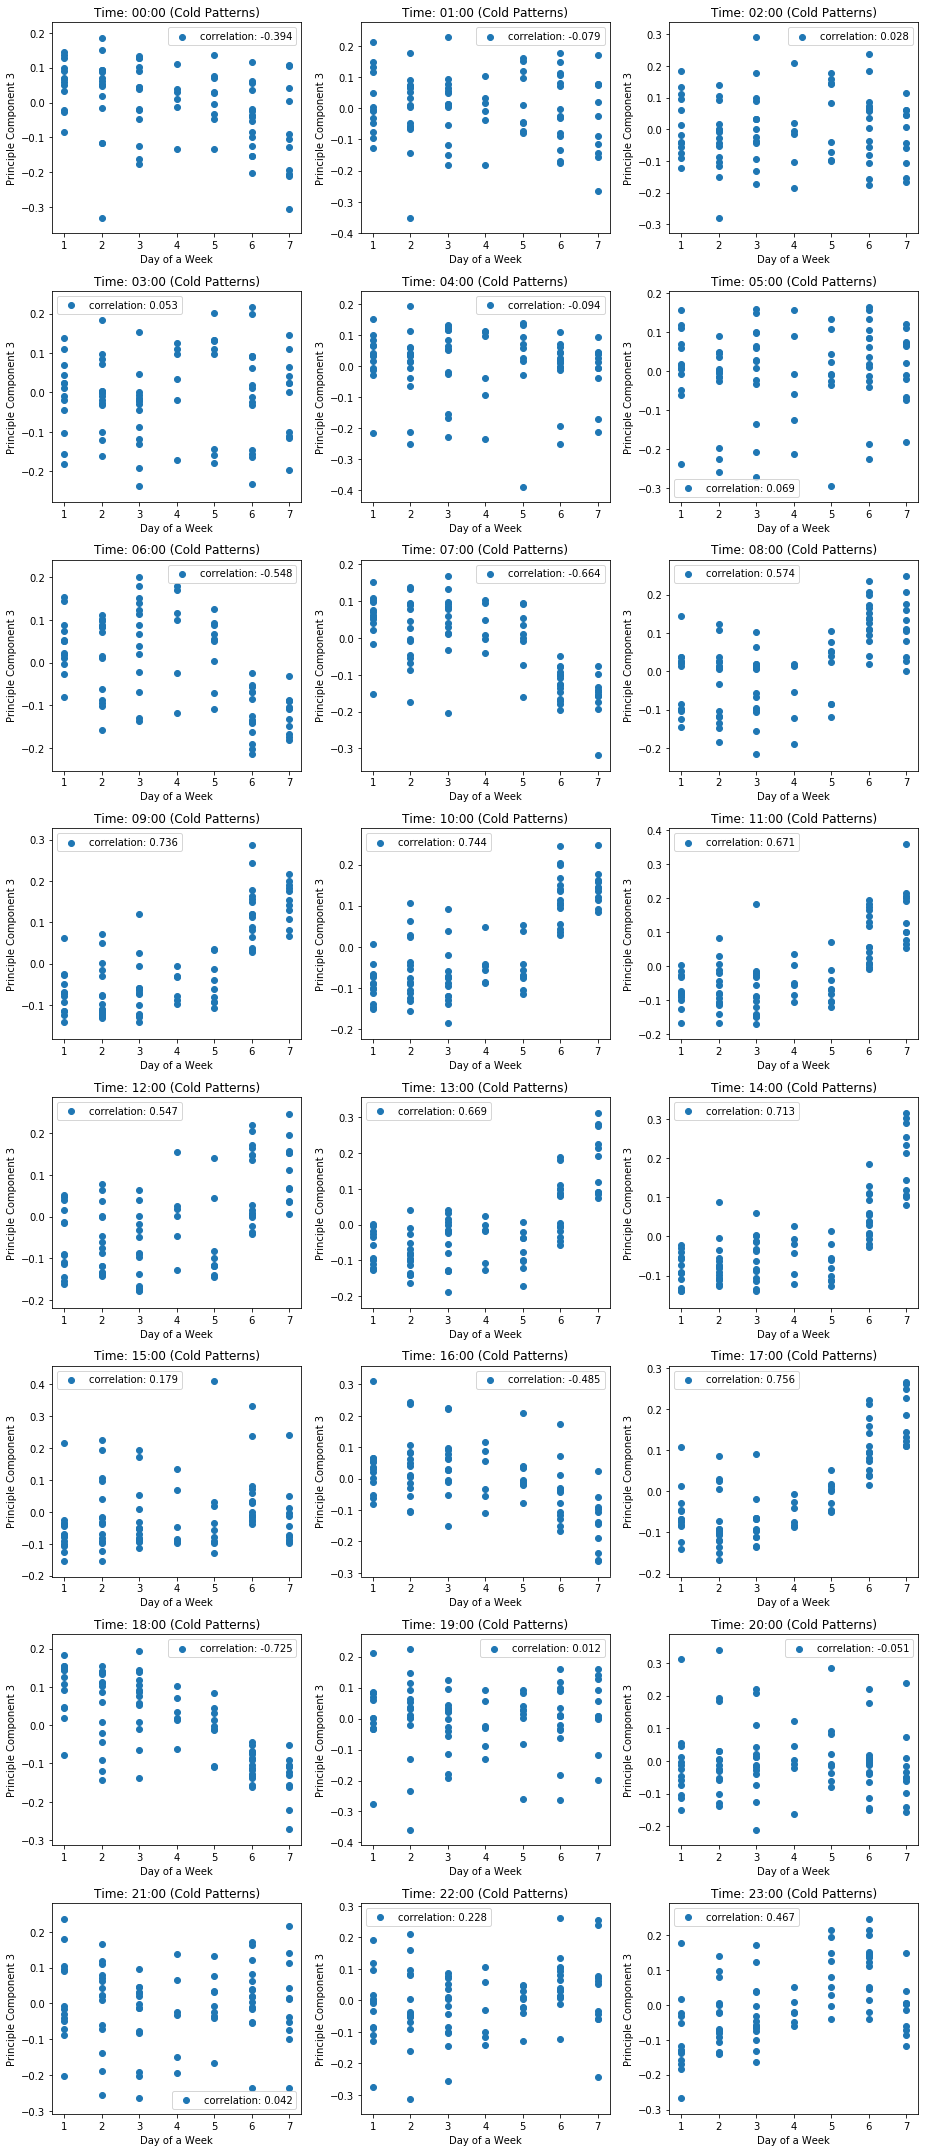

In [233]:
fig_all = plt.figure(figsize = (13,30))
for i in range(24):
    ax = fig_all.add_subplot(8, 3, i + 1)
    if i <= 9:
        x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains('0' + str(i) + ':00:00')]
        dayofWeek= pd.DataFrame(pd.to_datetime(x.GMT).dt.dayofweek)
        x.set_index('GMT', inplace = True)
        x = x.transpose().dropna() # data for the specific hour, and filtering out null value
        # PCA without standardization
        pca_nstd = PCA()
        principleComponents_nstd = pca_nstd.fit_transform(x)
        principleDf_nstd = pd.DataFrame(data = principleComponents_nstd)
        ax.scatter(dayofWeek + 1, pca_nstd.components_[2], label = 'correlation: ' + str(round(np.corrcoef(pca_nstd.components_[2], dayofWeek.GMT)[0][1], 3)))
        ax.set_title('Time: 0' + str(i) + ':00' + ' (Cold Patterns)')
        ax.legend()
        ax.set_xlabel('Day of a Week')
        ax.set_ylabel('Principle Component 3')
    else:
        x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains(str(i) + ':00:00')]
        dayofWeek= pd.DataFrame(pd.to_datetime(x.GMT).dt.dayofweek)
        x.set_index('GMT', inplace = True)
        x = x.transpose().dropna() # data for the specific hour, and filtering out null value
        # PCA without standardization
        pca_nstd = PCA()
        principleComponents_nstd = pca_nstd.fit_transform(x)
        principleDf_nstd = pd.DataFrame(data = principleComponents_nstd)
        ax.scatter(dayofWeek + 1, pca_nstd.components_[2], label = 'correlation: ' + str(round(np.corrcoef(pca_nstd.components_[2], dayofWeek.GMT)[0][1], 3)))
        ax.set_title('Time: ' + str(i) + ':00' + ' (Cold Patterns)')
        ax.legend()
        ax.set_xlabel('Day of a Week')
        ax.set_ylabel('Principle Component 3')
plt.tight_layout()

Milestone 4: K-mean clustering

The first three PCs are selected as inputs for K-mean clustering, due to their significance and interpretability

In [323]:
kmeans.cluster_centers_[1]

array([13.69917824,  0.46278999, -0.14054859])

In [348]:
np.square(kmeans.cluster_centers_[1]).sum() * 0.2

37.580282564512224

In [324]:
principleDf_nstd.iloc[kmeans.labels_ == 1][2].mean()

-0.14054858878175358

In [366]:
(7+189+441)/976

0.6526639344262295

In [379]:
test = principleDf_nstd.iloc[kmeans.labels_ == 0][[0,1,2]] - kmeans.cluster_centers_[0]
sum(np.square(test).sum(axis = 1) > np.square(kmeans.cluster_centers_[0]).sum() * 0.2)

0

In [385]:
test = principleDf_nstd.iloc[kmeans.labels_ == 1][[0,1,2]] - kmeans.cluster_centers_[1]
sum(np.square(test).sum(axis = 1) > np.square(kmeans.cluster_centers_[1]).sum() * 0.2)

63

In [384]:
test = principleDf_nstd.iloc[kmeans.labels_ == 2][[0,1,2]] - kmeans.cluster_centers_[2]
sum(np.square(test).sum(axis = 1) > np.square(kmeans.cluster_centers_[2]).sum() * 0.2)

118

In [383]:
test = principleDf_nstd.iloc[kmeans.labels_ == 3][[0,1,2]] - kmeans.cluster_centers_[3]
sum(np.square(test).sum(axis = 1) > np.square(kmeans.cluster_centers_[3]).sum() * 0.2)

1

In [395]:
tot = 0
for i in range(50):
    test = principleDf_nstd.iloc[kmeans.labels_ == i][[0,1,2]] - kmeans.cluster_centers_[i]
    tot = tot + sum(np.square(test).sum(axis = 1) > np.square(kmeans.cluster_centers_[i]).sum() * 0.2)
tot

184

In [359]:
kmeans.cluster_centers_[2]

array([-1.85445773,  0.06602678, -0.00851691])

In [363]:
principleDf_nstd.iloc[kmeans.labels_ == 2][[0,1,2]]

0         1         2
0   -1.620185 -0.592959  0.244397
1   -1.661366  0.029253  0.061899
3   -3.115467  0.383060  0.024909
4   -1.036400 -0.267317 -0.031575
6   -2.005731 -0.020938  0.093429
7   -0.457337 -0.220966  0.163222
8   -0.910533 -0.124833  0.495237
9   -4.250748  0.316033 -0.057331
10   0.486901  0.326302  0.216783
11  -1.087783 -0.151802 -0.045485
12  -2.921105  0.187878  0.423850
15  -1.423560  0.787517 -0.513145
16  -3.525139  0.277260  0.123376
17  -1.270571 -0.205685  0.066542
18  -0.517938  0.138809  0.544490
19  -3.771370  0.307557 -0.021056
20  -3.307719  0.497644 -0.369094
21  -0.318171 -0.749210 -0.219996
23  -2.971839  0.186583 -0.011353
25  -0.063193  0.007280 -0.331385
26  -3.566003  0.242916 -0.037875
28  -1.752423  0.510274 -0.254782
30  -0.391012 -0.254169  0.356971
31  -1.725858 -0.521983 -0.489599
33  -2.369143  0.292235 -0.133033
34  -2.125833  0.031555  0.501008
35  -3.796201  0.239104 -0.055387
36  -3.353681  0.030313  0.027769
37  -2.435440  1.288151 -0.386179
38  -1.404894 -0.233757  0.296549
..        ...       ...       ...
929 -1.122964 -0.194919 -0.052467
930 -0.284159 -0.040311  0.112011
932 -2.311782 -0.236141 -0.027485
934 -2.632756  0.420530  0.071184
936 -1.823435 -0.293531  0.044192
937 -1.244995 -0.013347  0.268433
939 -1.983013  0.210881 -0.015949
940  0.511826  0.004723 -0.185251
942 -1.332564 -0.026110  0.298990
943 -3.094512  0.175275 -0.118654
944 -1.892950 -0.259107  0.049288
946 -1.957914  0.168002 -0.091326
949 -0.467085 -0.334687  0.045369
951 -2.299498 -0.168591  0.081136
952 -2.644144 -0.190392 -0.248083
953  0.122055 -0.121570  0.188775
955 -3.158028 -0.056186  0.123294
957 -2.924551  0.102112 -0.017738
958 -1.291199  0.514658 -0.156659
959 -2.276154 -0.029111  0.023763
961 -0.412617  0.395995  0.588982
966 -3.829053  0.294873 -0.057931
967 -2.813216  0.749018  0.118078
968 -1.091564  0.459018  0.020419
969 -1.904474  0.811493  0.245285
971 -0.100192 -0.858034  0.524805
972 -2.653057 -0.064930  0.011090
973 -1.242653  0.151862 -0.072275
974 -2.789607  0.307940  0.075500
975 -1.653819  0.232130 -0.463952

[683 rows x 3 columns]

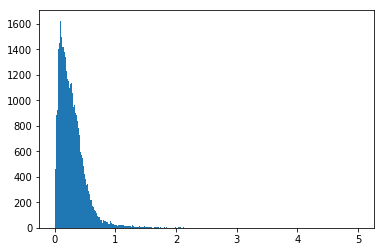

In [36]:
test=pd.DataFrame(x.iloc[kmeans.labels_ == 0])
test = test.values.flatten()
plt.hist(test, bins=500)
plt.show()

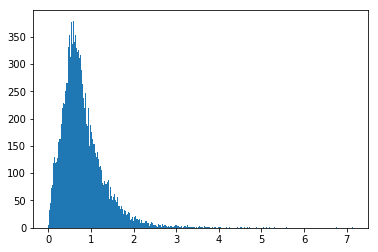

In [37]:
test=pd.DataFrame(x.iloc[kmeans.labels_ == 1])
test = test.values.flatten()
plt.hist(test, bins=500)
plt.show()

In [60]:
len(kmeans.labels_ == 2)

976

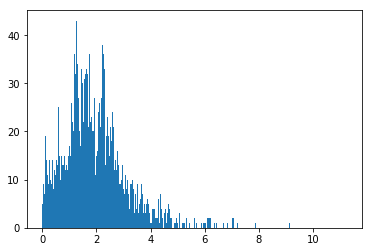

In [38]:
test=pd.DataFrame(x.iloc[kmeans.labels_ == 2])
test = test.values.flatten()
plt.hist(test, bins=500)
plt.show()

In [ ]:
# try to select the 
df_tou1h_nf_cold.GMT.str.contains('0' + str(i) + ':00:00')
dayofWeek= pd.DataFrame(pd.to_datetime(x.GMT).dt.dayofweek)

In [96]:
df_wea1h_nf_cold

GMT     TempC      TempF
0     2013-01-01 00:00:00  7.000000  45.000000
1     2013-01-01 01:00:00  6.666667  44.333333
2     2013-01-01 02:00:00  6.333333  43.666667
3     2013-01-01 03:00:00  6.000000  43.000000
4     2013-01-01 04:00:00  5.333333  41.333333
5     2013-01-01 05:00:00  4.666667  39.666667
6     2013-01-01 06:00:00  4.000000  38.000000
7     2013-01-01 07:00:00  3.666667  38.000000
8     2013-01-01 08:00:00  3.333333  38.000000
9     2013-01-01 09:00:00  3.000000  38.000000
10    2013-01-01 10:00:00  4.000000  39.666667
11    2013-01-01 11:00:00  5.000000  41.333333
12    2013-01-01 12:00:00  6.000000  43.000000
13    2013-01-01 13:00:00  6.000000  43.000000
14    2013-01-01 14:00:00  6.000000  43.000000
15    2013-01-01 15:00:00  6.000000  43.000000
16    2013-01-01 16:00:00  5.333333  41.666667
17    2013-01-01 17:00:00  4.666667  40.333333
18    2013-01-01 18:00:00  4.000000  39.000000
19    2013-01-01 19:00:00  3.666667  38.333333
20    2013-01-01 20:00:00  3.333333  37.666667
21    2013-01-01 21:00:00  3.000000  37.000000
22    2013-01-01 22:00:00  2.666667  36.666667
23    2013-01-01 23:00:00  2.333333  36.333333
24    2013-01-02 00:00:00  2.000000  36.000000
25    2013-01-02 01:00:00  2.000000  36.000000
26    2013-01-02 02:00:00  2.000000  36.000000
27    2013-01-02 03:00:00  2.000000  36.000000
28    2013-01-02 04:00:00  2.000000  35.666667
29    2013-01-02 05:00:00  2.000000  35.333333
...                   ...       ...        ...
8682  2013-12-28 18:00:00  6.000000  42.000000
8683  2013-12-28 19:00:00  6.000000  42.000000
8684  2013-12-28 20:00:00  6.000000  42.000000
8685  2013-12-28 21:00:00  6.000000  42.000000
8686  2013-12-28 22:00:00  5.000000  40.666667
8687  2013-12-28 23:00:00  4.000000  39.333333
8736  2013-12-31 00:00:00  9.000000  48.000000
8737  2013-12-31 01:00:00  9.000000  48.000000
8738  2013-12-31 02:00:00  9.000000  48.000000
8739  2013-12-31 03:00:00  9.000000  48.000000
8740  2013-12-31 04:00:00  9.000000  48.000000
8741  2013-12-31 05:00:00  9.000000  48.000000
8742  2013-12-31 06:00:00  9.000000  48.000000
8743  2013-12-31 07:00:00  9.000000  48.000000
8744  2013-12-31 08:00:00  9.000000  48.000000
8745  2013-12-31 09:00:00  9.000000  48.000000
8746  2013-12-31 10:00:00  9.000000  48.000000
8747  2013-12-31 11:00:00  9.000000  48.000000
8748  2013-12-31 12:00:00  9.000000  48.000000
8749  2013-12-31 13:00:00  9.000000  48.000000
8750  2013-12-31 14:00:00  9.000000  48.000000
8751  2013-12-31 15:00:00  9.000000  48.000000
8752  2013-12-31 16:00:00  9.000000  48.000000
8753  2013-12-31 17:00:00  9.000000  48.000000
8754  2013-12-31 18:00:00  9.000000  48.000000
8755  2013-12-31 19:00:00  9.000000  48.000000
8756  2013-12-31 20:00:00  9.000000  48.000000
8757  2013-12-31 21:00:00  9.000000  48.000000
8758  2013-12-31 22:00:00  9.000000  48.000000
8759  2013-12-31 23:00:00  9.000000  48.000000

[1992 rows x 3 columns]

In [110]:
np.round(df_wea1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains('00:00:00')]['TempC'].values)

array([ 7.,  2.,  8.,  6.,  7.,  8.,  1.,  0., -2., -2., -3.,  0., -1.,
        1.,  5.,  6.,  4.,  2.,  6.,  3.,  0.,  0.,  2.,  2.,  1., -3.,
       -2., -2.,  4.,  0.,  3.,  6.,  7.,  1., -1., -2.,  0., -1.,  1.,
        1.,  0., -1., -1.,  3., 13., 11.,  7., 11., 10.,  9.,  8.,  5.,
       10., 11.,  7.,  5.,  6.,  7.,  8.,  3.,  3.,  4.,  5.,  4.,  3.,
        5.,  4.,  5.,  4.,  7.,  7.,  5.,  7.,  7.,  8., 10.,  7.,  9.,
        8.,  5.,  9.,  6.,  9.])

In [104]:
df_wea1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains('00:00:00')]['TempC']

0        7.0
24       2.0
48       8.0
96       6.0
120      7.0
192      8.0
264      1.0
312      0.0
336     -2.0
408     -2.0
504     -3.0
528      0.0
552     -1.0
600      1.0
624      5.0
720      6.0
744      4.0
768      2.0
816      6.0
864      3.0
1008     0.0
1032     0.0
1056     2.0
1104     2.0
1176     1.0
1272    -3.0
1296    -2.0
1320    -2.0
1464     4.0
1488     0.0
        ... 
7560    11.0
7584     7.0
7632     5.0
7656     6.0
7680     7.0
7704     8.0
7728     3.0
7752     3.0
7800     4.0
7824     5.0
7848     4.0
7872     3.0
8040     5.0
8064     4.0
8112     5.0
8136     4.0
8208     7.0
8232     7.0
8256     5.0
8328     7.0
8400     7.0
8424     8.0
8496    10.0
8520     7.0
8544     9.0
8568     8.0
8592     5.0
8640     9.0
8664     6.0
8736     9.0
Name: TempC, Length: 83, dtype: float64

In [125]:
len()

977

In [131]:
df_wea1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains('00:00:00')]
test = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains('00:00:00')]
# test.set_index('GMT', inplace = True)
test = test.dropna(axis = 'columns') 
test = test[test.columns[np.insert(kmeans.labels_ == 2, 0, True)]]
test['TempC'] = np.round(df_wea1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains('00:00:00')]['TempC'].values)
test[test['TempC'] == 7]

GMT  D0163  D0196  D0203  D0234  D0242  D0269  D0276  \
0     2013-01-01 00:00:00  0.534  1.148  1.560  0.429  0.254  1.767  2.577   
120   2013-01-06 00:00:00  0.544  2.070  1.642  0.188  0.237  1.600  2.591   
1608  2013-03-09 00:00:00  0.220  1.264  1.365  0.383  0.402  1.729  0.341   
7368  2013-11-04 00:00:00  0.269  0.917  1.251  0.218  0.110  0.689  1.391   
7584  2013-11-13 00:00:00  0.230  0.865  1.393  0.233  0.196  0.633  1.418   
7680  2013-11-17 00:00:00  0.213  1.173  0.977  0.820  0.183  0.702  1.657   
8208  2013-12-09 00:00:00  0.188  1.297  1.021  0.180  0.127  0.571  1.384   
8232  2013-12-10 00:00:00  0.144  0.862  1.141  0.290  0.246  0.848  2.255   
8328  2013-12-14 00:00:00  0.223  1.061  1.374  0.295  0.202  0.606  1.069   
8400  2013-12-17 00:00:00  0.184  1.265  1.026  0.259  0.456  0.593  1.456   
8520  2013-12-22 00:00:00  0.225  1.675  1.420  0.357  0.203  0.655  3.375   

      D0296  D0336  ...    D0818  D0824  D0860  D0891  D0899  D0918  D0941  \
0     2.073  2.124  ...    0.027  0.083  0.099  1.482  0.628  2.565  3.536   
120   2.275  0.642  ...    0.183  0.025  0.230  1.013  0.464  2.357  2.183   
1608  2.052  1.163  ...    0.043  0.025  0.146  1.108  0.472  0.488  1.952   
7368  0.125  1.125  ...    0.127  0.066  0.182  1.035  3.402  0.434  0.804   
7584  1.143  0.810  ...    0.074  0.026  0.127  2.024  1.879  0.692  1.134   
7680  1.248  1.175  ...    0.080  0.077  0.285  0.556  3.125  0.261  1.361   
8208  2.141  0.651  ...    0.075  0.021  0.154  0.642  2.277  0.279  1.716   
8232  2.315  0.555  ...    0.341  0.054  0.184  0.383  2.361  0.331  1.677   
8328  2.140  0.509  ...    0.099  0.070  0.126  0.940  2.233  0.658  0.824   
8400  2.242  0.641  ...    0.349  0.050  0.100  1.561  2.356  0.323  0.734   
8520  2.251  0.703  ...    0.565  0.051  0.231  0.938  1.554  0.295  2.339   

      D0970  D1014  TempC  
0     0.568  0.381    7.0  
120   0.459  1.397    7.0  
1608  0.057  0.279    7.0  
7368  0.079  0.522    7.0  
7584  0.269  2.017    7.0  
7680  0.994  0.904    7.0  
8208  0.145  0.439    7.0  
8232  0.220  1.007    7.0  
8328  0.137  1.197    7.0  
8400  0.195  3.248    7.0  
8520  0.321  0.282    7.0  

[11 rows x 38 columns]

In [399]:
x

GMT    2013-01-01 23:00:00  2013-01-02 23:00:00  2013-01-03 23:00:00  \
D0000                0.323                0.232                0.315   
D0001                0.269                0.452                0.375   
D0002                0.488                0.445                0.408   
D0003                0.241                0.153                0.156   
D0005                0.293                0.458                0.352   
D0006                0.538                0.973                0.881   
D0007                0.495                0.357                0.402   
D0008                0.533                0.268                0.457   
D0009                0.110                0.327                0.655   
D0010                0.019                0.028                0.028   
D0011                0.376                0.613                0.349   
D0012                0.381                0.291                0.515   
D0013                0.130                0.094                0.226   
D0014                1.290                1.450                0.843   
D0015                0.352                0.328                0.290   
D0016                0.352                0.067                0.069   
D0017                0.062                0.068                0.077   
D0018                0.066                0.532                0.613   
D0019                0.546                0.510                0.495   
D0020                0.226                0.062                0.228   
D0021                0.000                0.067                0.047   
D0022                0.299                0.412                0.178   
D0023                0.941                0.730                0.567   
D0024                0.137                0.138                0.137   
D0025                1.151                1.336                1.414   
D0026                0.124                0.560                0.501   
D0027                0.131                0.094                0.090   
D0028                0.652                0.704                0.904   
D0030                0.094                0.115                0.121   
D0031                0.815                1.418                0.509   
...                    ...                  ...                  ...   
D0995                0.150                0.046                0.139   
D0996                1.576                0.980                0.908   
D0997                0.764                0.740                0.925   
D0998                0.414                0.413                0.450   
D0999                0.802                0.778                0.931   
D1000                0.204                0.201                0.229   
D1001                0.157                0.146                0.130   
D1002                0.514                0.675                0.575   
D1003                0.615                0.525                0.665   
D1004                0.116                0.153                0.105   
D1005                0.477                1.906                1.074   
D1006                0.278                0.095                0.129   
D1007                0.309                0.313                0.404   
D1008                0.174                0.533                0.311   
D1009                0.810                0.636                0.308   
D1010                0.384                0.425                0.264   
D1011                0.643                0.746                0.482   
D1012                0.084                1.179                0.214   
D1013                0.970                0.491                0.613   
D1014                0.883                1.531                1.784   
D1015                0.031                0.036                0.047   
D1016                0.121                0.166                0.072   
D1017                0.656                0.394                0.420   
D1018                0.294              

In [400]:
principleDf_nstd

0         1         2         3         4         5         6   \
0    -1.620185 -0.592959  0.244397  0.082625 -0.010647  0.088016 -0.525885   
1    -1.661366  0.029253  0.061899  0.125899 -0.294371  0.127066  0.073910   
2     0.782621 -0.932118  0.110608  0.531155 -0.226259 -0.091804 -0.260152   
3    -3.115467  0.383060  0.024909  0.002751  0.006755  0.080558  0.008471   
4    -1.036400 -0.267317 -0.031575 -0.055888  0.021009  0.166625 -0.030766   
5     1.193248  0.255104 -0.025588  0.182918  0.616303  0.041975 -0.188161   
6    -2.005731 -0.020938  0.093429 -0.069729 -0.007040 -0.187871 -0.002429   
7    -0.457337 -0.220966  0.163222  0.144747  0.043070 -0.210830  0.128018   
8    -0.910533 -0.124833  0.495237 -0.178256  0.120574  0.173278 -0.204780   
9    -4.250748  0.316033 -0.057331  0.077776 -0.040329  0.076140 -0.006323   
10    0.486901  0.326302  0.216783  0.657936  0.162890  0.371985 -0.471605   
11   -1.087783 -0.151802 -0.045485 -0.176006 -0.009662 -0.416894  0.237806   
12   -2.921105  0.187878  0.423850 -0.243131 -0.010236  0.180619  0.043148   
13    6.706232 -0.973902 -0.522077  0.193592  0.372854 -0.295330  0.402360   
14    2.324176 -3.774582  0.160641  1.195161 -0.399566  0.279293 -0.517375   
15   -1.423560  0.787517 -0.513145 -0.194819  0.378354  0.242304  0.168039   
16   -3.525139  0.277260  0.123376  0.105541  0.015088  0.207085 -0.078257   
17   -1.270571 -0.205685  0.066542 -0.060631  0.283756 -0.048660 -0.013711   
18   -0.517938  0.138809  0.544490 -0.114934  0.225885 -0.183973  0.048470   
19   -3.771370  0.307557 -0.021056  0.066666  0.038512  0.053755 -0.021809   
20   -3.307719  0.497644 -0.369094 -0.053913  0.059315  0.063715 -0.142519   
21   -0.318171 -0.749210 -0.219996  0.465679 -0.207601 -0.195585  0.215405   
22    4.798980 -2.625601 -0.033076  0.602287  0.113668  0.048328 -1.211129   
23   -2.971839  0.186583 -0.011353 -0.000966 -0.007722  0.109645  0.004531   
24    4.784678 -0.503089 -0.402069  0.066491 -0.043217 -0.673592 -0.177555   
25   -0.063193  0.007280 -0.331385  0.032606 -0.047221 -0.070550  0.301002   
26   -3.566003  0.242916 -0.037875  0.065599 -0.012322  0.051448 -0.005737   
27    1.649383 -0.714390  0.338527 -0.252104  0.192421  0.024651  0.204230   
28   -1.752423  0.510274 -0.254782  0.228796  0.012142  0.158654 -0.165661   
29    2.307862 -0.098085 -0.103248  0.034114  0.342416  0.062050  0.052575   
..         ...       ...       ...       ...       ...       ...       ...   
946  -1.957914  0.168002 -0.091326 -0.037325 -0.190861  0.445503 -0.100036   
947   3.450713 -1.197278  0.191761  0.057937 -0.215177 -0.564760 -0.491968   
948   4.480616 -2.391611  0.203516  0.084416  0.325329 -0.437473 -0.365050   
949  -0.467085 -0.334687  0.045369  0.116622 -0.009395  0.024059  0.014551   
950   2.305457 -0.257312  0.423576 -0.235972  0.485655 -0.329200  0.636216   
951  -2.299498 -0.168591  0.081136  0.070122  0.032748  0.099033 -0.027820   
952  -2.644144 -0.190392 -0.248083  0.126023 -0.095726  0.114445  0.036249   
953   0.122055 -0.121570  0.188775 -0.064073  0.129777 -0.154312 -0.037323   
954   1.678081 -1.425741  0.123169 -0.129934  0.430785 -0.112226  0.331886   
955  -3.158028 -0.056186  0.123294  0.029846 -0.050082  0.039191 -0.313752   
956   4.341515  2.473694 -0.731853 -1.748747 -0.075586 -1.429852  0.118220   
957  -2.924551  0.102112 -0.017738  0.049881  0.013587  0.153566  0.026181   
958  -1.291199  0.514658 -0.156659 -0.072014  0.176546 -0.290898 -0.153704   
959  -2.276154 -0.029111  0.023763  0.194704  0.056603  0.054011  0.146348   
960   2.043192 -0.771311  0.487051 -0.209805  0.485227  0.365240  0.101061   
961  -0.412617  0.395995  0.588982  0.221058  0.298410  1.022601 -0.492644   
962   0.934248 -0.050027 -0.086601  0.039311  0.131611 -0.139582 -0.077743   
963   3.550927 -0.234097 -0.085144  1.243873  1.862715  0.305639 -0.792303   
964   7.384993  1.329712  0.960455  1.855905  0.226369 -0.027942 -0.729786   
965  12.112826 -3.100696 -0.089917

In [402]:
len(kmeans.labels_)

976

In [39]:
df_tou1h_nf_cold

GMT  D0000  D0001  D0002  D0003  D0004  D0005  D0006  \
0     2013-01-01 00:00:00  1.447  0.429  0.451  0.155  0.397  0.106  0.307   
1     2013-01-01 01:00:00  0.336  0.377  0.467  0.153  0.227  0.109  0.365   
2     2013-01-01 02:00:00  0.244  0.151  0.490  0.154  0.126  0.108  0.060   
3     2013-01-01 03:00:00  0.213  0.155  0.580  0.153  0.057  0.109  0.067   
4     2013-01-01 04:00:00  0.210  0.121  0.579  0.156  0.061  0.107  0.056   
5     2013-01-01 05:00:00  0.198  0.128  0.509  0.948  0.076  0.194  0.052   
6     2013-01-01 06:00:00  0.202  0.120  0.594  2.842  0.158  0.171  0.058   
7     2013-01-01 07:00:00  0.167  0.126  0.616  0.534  0.062  0.170  0.097   
8     2013-01-01 08:00:00  0.360  0.323  0.525  0.153  0.056  0.190  0.053   
9     2013-01-01 09:00:00  0.178  0.463  0.482  0.153  0.231  0.136  0.096   
10    2013-01-01 10:00:00  0.202  0.295  0.481  0.436  0.784  0.125  0.179   
11    2013-01-01 11:00:00  0.188  0.214  0.499  0.152  0.337  0.110  0.198   
12    2013-01-01 12:00:00  0.154  0.219  0.489  0.152  0.204  0.107  0.390   
13    2013-01-01 13:00:00  0.429  0.140  0.439  0.152  0.278  0.213  1.847   
14    2013-01-01 14:00:00  0.494  0.151  0.440  0.421  0.287  0.360  0.520   
15    2013-01-01 15:00:00  0.190  0.115  0.438  0.222  0.313  0.420  0.599   
16    2013-01-01 16:00:00  0.892  0.308  0.671  0.883  0.363  0.387  0.866   
17    2013-01-01 17:00:00  0.411  0.401  0.618  0.252  0.803  0.413  0.862   
18    2013-01-01 18:00:00  0.503  0.511  0.594  0.240  0.852  0.372  1.653   
19    2013-01-01 19:00:00  0.400  0.990  0.582  0.240  0.705  0.383  0.638   
20    2013-01-01 20:00:00  0.723  0.566  0.580  0.240  1.067  0.385  0.665   
21    2013-01-01 21:00:00  1.056  0.454  0.572  0.239  0.628  0.348  0.607   
22    2013-01-01 22:00:00  0.624  0.598  0.502  0.240  0.374  0.268  0.556   
23    2013-01-01 23:00:00  0.323  0.269  0.488  0.241  0.349  0.293  0.538   
24    2013-01-02 00:00:00  0.358  0.153  0.463  0.169  0.356  0.255  0.436   
25    2013-01-02 01:00:00  0.181  0.230  0.507  0.156  0.317  0.164  0.170   
26    2013-01-02 02:00:00  0.092  0.127  0.510  0.154  0.275  0.143  0.144   
27    2013-01-02 03:00:00  0.097  0.099  0.510  0.153  0.269  0.156  0.144   
28    2013-01-02 04:00:00  0.324  0.126  0.534  0.154  0.164  0.163  0.142   
29    2013-01-02 05:00:00  0.095  0.160  0.616  0.948  0.071  0.177  0.141   
...                   ...    ...    ...    ...    ...    ...    ...    ...   
8682  2013-12-28 18:00:00  0.735  0.480  2.618  0.185  1.001  0.336  2.567   
8683  2013-12-28 19:00:00  0.560  1.060  1.589  0.186  0.699  0.430  1.361   
8684  2013-12-28 20:00:00  0.591  0.287  0.717  0.187  0.622  0.422  1.200   
8685  2013-12-28 21:00:00  0.509  0.289  1.223  0.187  0.443  0.452  1.114   
8686  2013-12-28 22:00:00  0.376  0.443  1.262  0.187  0.327  0.377  1.079   
8687  2013-12-28 23:00:00  0.295  0.248  1.043  0.151  0.211  0.348  0.521   
8736  2013-12-31 00:00:00  0.335  0.107  0.415  0.101  0.295  0.338  0.624   
8737  2013-12-31 01:00:00  0.191  0.088  0.355  0.099  0.107  0.273  1.261   
8738  2013-12-31 02:00:00  0.172  0.083  0.304  0.100  0.034  0.250  0.384   
8739  2013-12-31 03:00:00  0.114  0.066  0.290  0.100  0.035  0.184  0.266   
8740  2013-12-31 04:00:00  0.093  0.062  0.307  0.099  0.014  0.153  0.281   
8741  2013-12-31 05:00:00  0.289  0.082  0.285  1.479  0.054  0.141  0.175   
8742  2013-12-31 06:00:00  0.105  0.085  0.287  2.803  0.120  0.129  0.227   
8743  2013-12-31 07:00:00  0.087  0.141  0.300  0.200  0.038  0.297  0.704   
8744  2013-12-31 08:00:00  0.096  0.211  0.282  0.260  1.024  0.336  0.376   
8745  2013-12-31 09:00:00  0.107  0.500  0.278  0.101  0.335  0.299  0.474   
8746  2013-12-31 10:00:00  0.106  0.313  0.306  0.098  0.352  0.254  0.417   
8747  2013-12-31 11:00:00  0.109  0.107  0.272  0.099  0.268  0.421  1.350   
8748  2013-12-31 12:00:00  0.086  0.162  0.317  0.098  0.310  0.243  2.965   
8749  2013-12-31 13:00:00  0.094  0.204  0.4

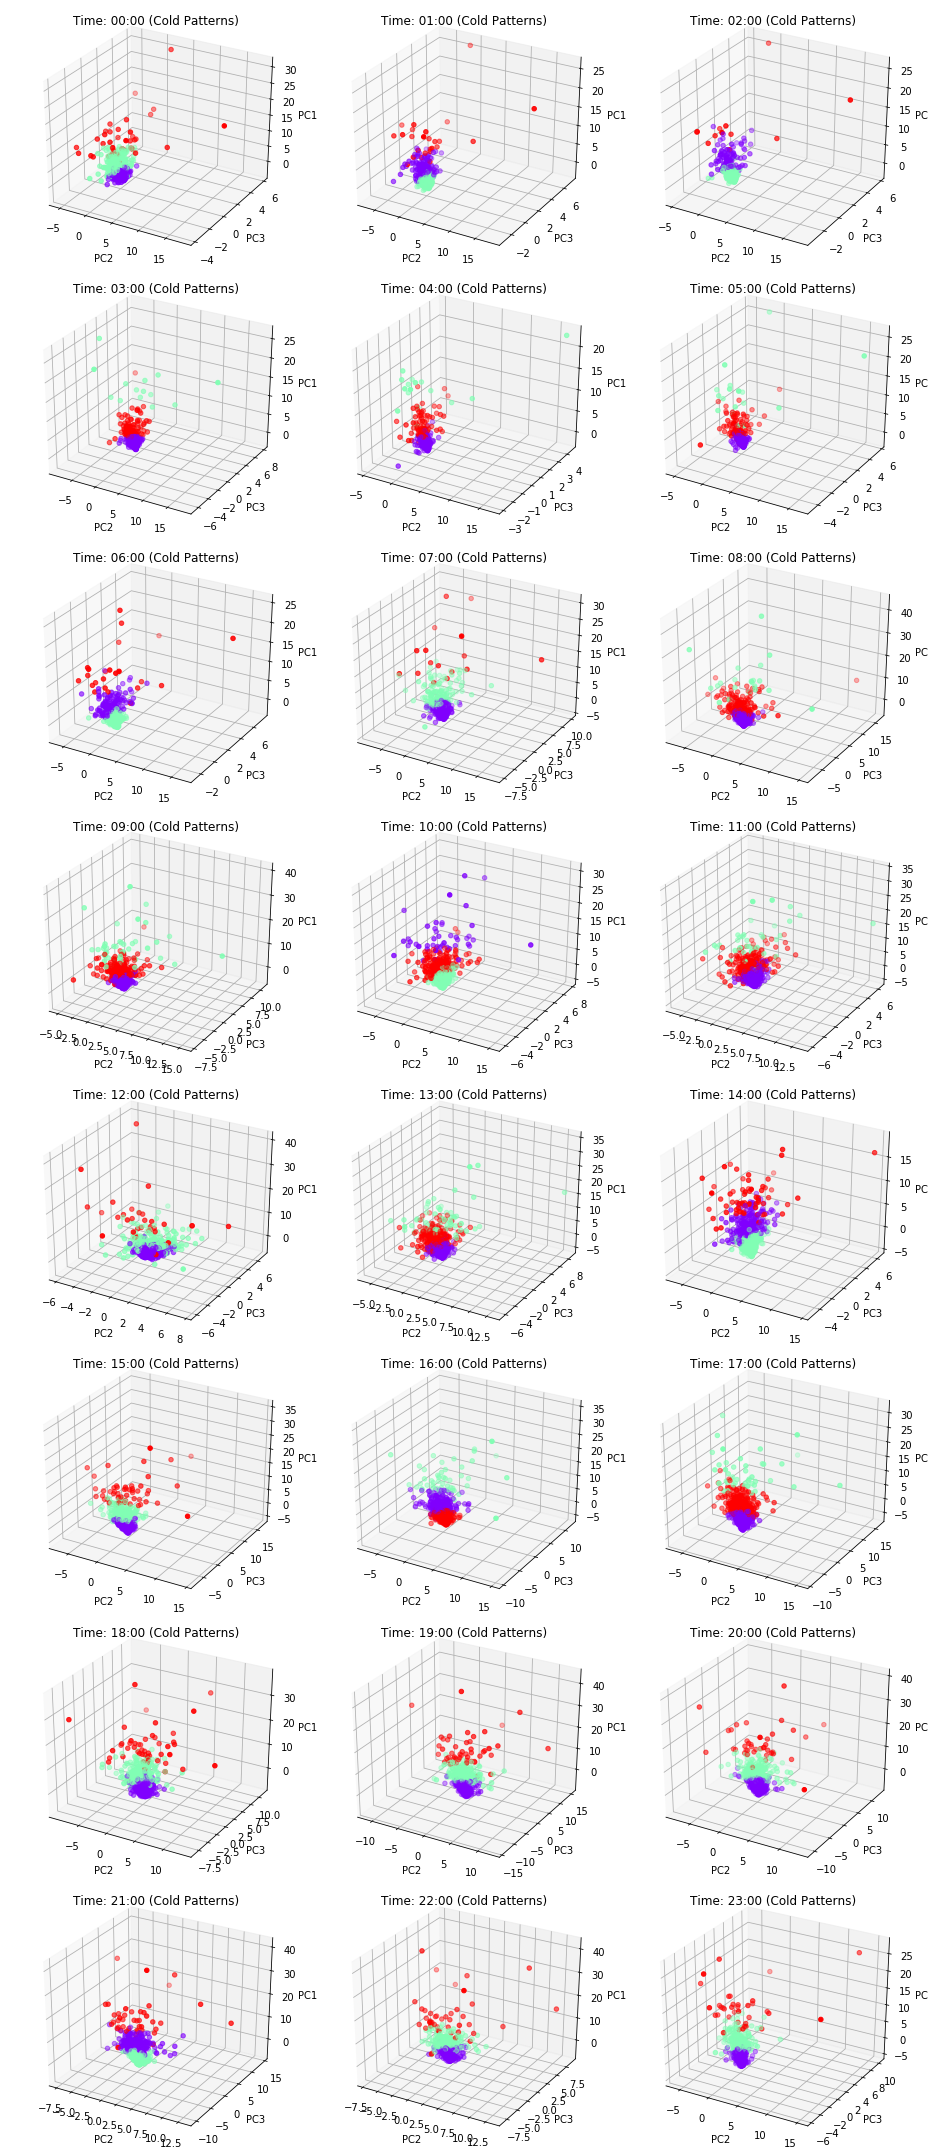

In [7]:
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D 
fig_all = plt.figure(figsize = (13,30))
for i in range(24):
    ax = fig_all.add_subplot(8, 3, i + 1, projection = '3d')
    if i <= 9:
        x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains('0' + str(i) + ':00:00')]
        dayofWeek= pd.DataFrame(pd.to_datetime(x.GMT).dt.dayofweek)
        x.set_index('GMT', inplace = True)
        x = x.transpose().dropna() # data for the specific hour, and filtering out null value
        # PCA without standardization
        pca_nstd = PCA()
        principleComponents_nstd = pca_nstd.fit_transform(x)
        principleDf_nstd = pd.DataFrame(data = principleComponents_nstd)
        kmeans = KMeans(n_clusters = 3).fit(principleDf_nstd.iloc[:,:3])
        ax.scatter(principleDf_nstd[1], principleDf_nstd[2], principleDf_nstd[0], c = (kmeans.labels_*10), cmap = 'rainbow')
        # what is the center of the cluster
        kmeans.cluster_centers_
        ax.set_title('Time: 0' + str(i) + ':00' + ' (Cold Patterns)')
        ax.set_xlabel('PC2')
        ax.set_ylabel('PC3')
        ax.set_zlabel('PC1')
    else:
        x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains(str(i) + ':00:00')]
        dayofWeek= pd.DataFrame(pd.to_datetime(x.GMT).dt.dayofweek)
        x.set_index('GMT', inplace = True)
        x = x.transpose().dropna() # data for the specific hour, and filtering out null value
        # PCA without standardization
        pca_nstd = PCA()
        principleComponents_nstd = pca_nstd.fit_transform(x)
        principleDf_nstd = pd.DataFrame(data = principleComponents_nstd)
        kmeans = KMeans(n_clusters = 3).fit(principleDf_nstd.iloc[:,:3])
        ax.scatter(principleDf_nstd[1], principleDf_nstd[2], principleDf_nstd[0], c = (kmeans.labels_*10), cmap = 'rainbow')
        ax.set_title('Time: ' + str(i) + ':00' + ' (Cold Patterns)')
        ax.set_xlabel('PC2')
        ax.set_ylabel('PC3')
        ax.set_zlabel('PC1')
plt.tight_layout()

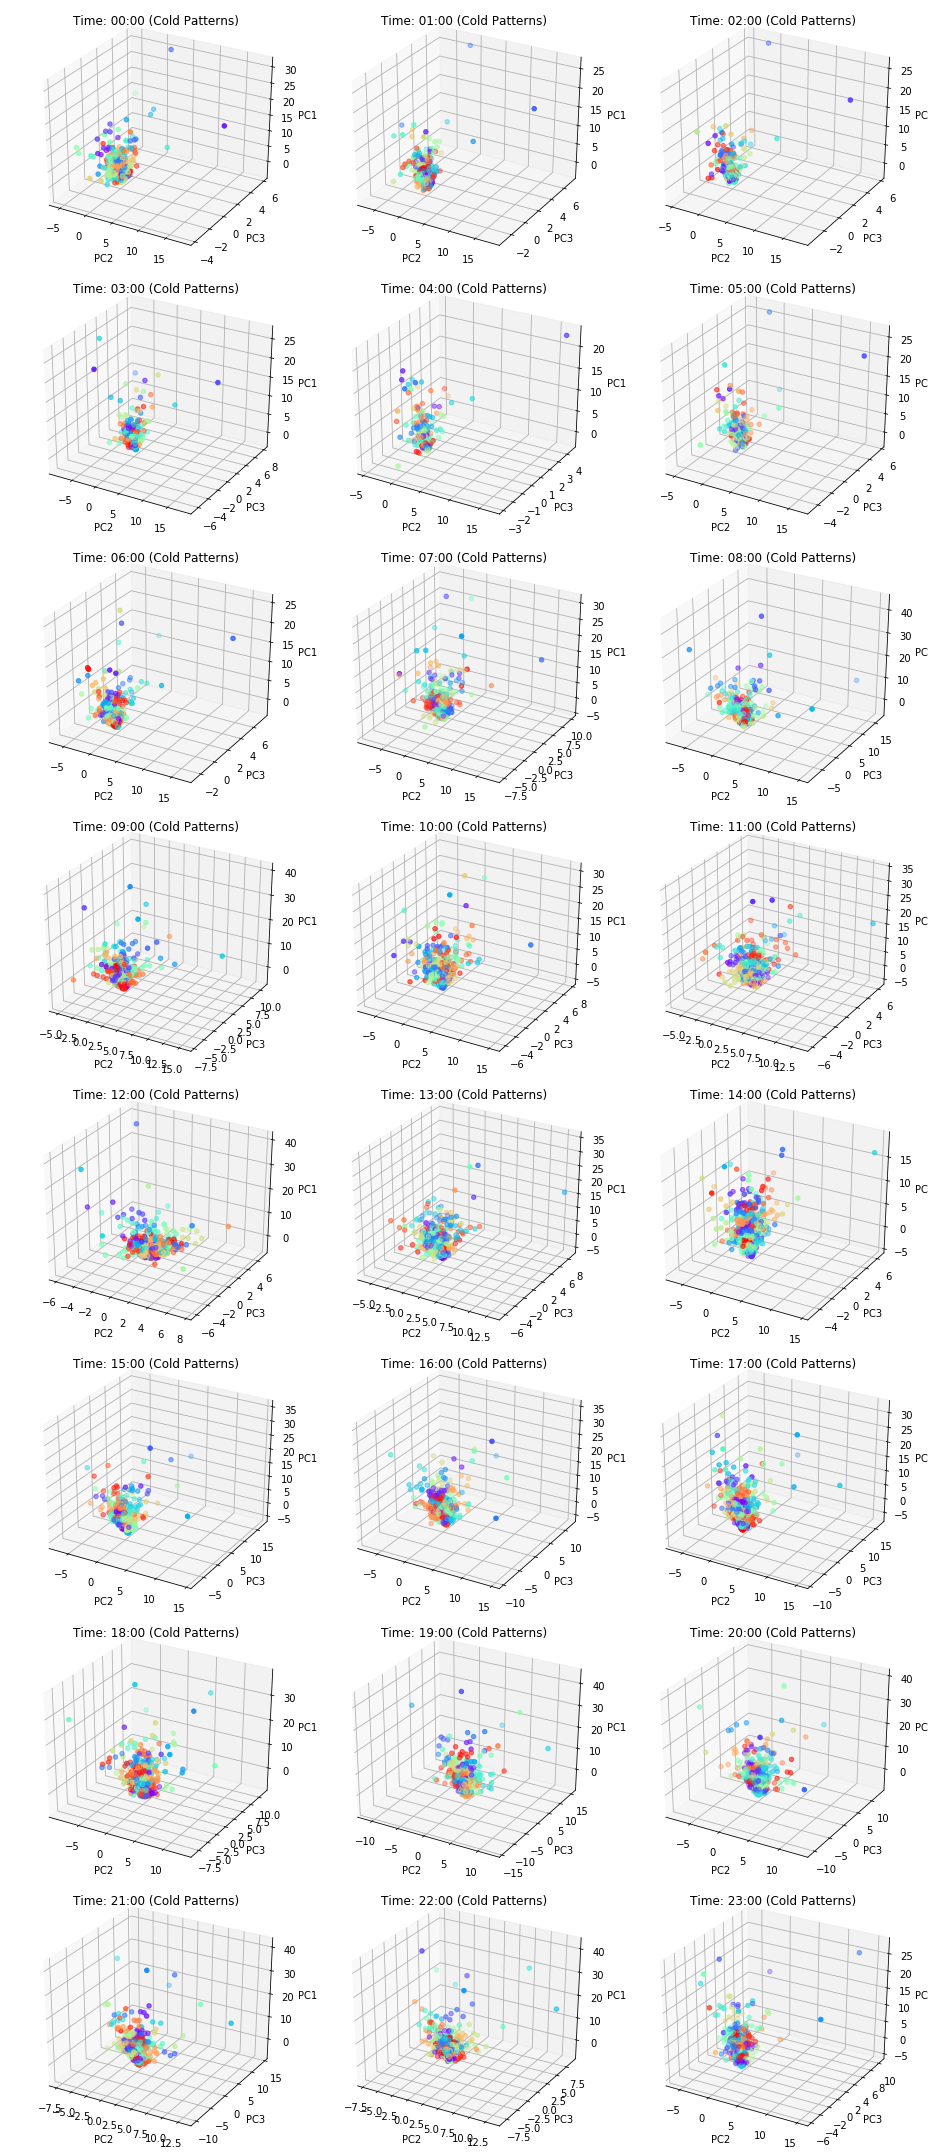

In [394]:
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D 
fig_all = plt.figure(figsize = (13,30))
for i in range(24):
    ax = fig_all.add_subplot(8, 3, i + 1, projection = '3d')
    if i <= 9:
        x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains('0' + str(i) + ':00:00')]
        dayofWeek= pd.DataFrame(pd.to_datetime(x.GMT).dt.dayofweek)
        x.set_index('GMT', inplace = True)
        x = x.transpose().dropna() # data for the specific hour, and filtering out null value
        # PCA without standardization
        pca_nstd = PCA()
        principleComponents_nstd = pca_nstd.fit_transform(x)
        principleDf_nstd = pd.DataFrame(data = principleComponents_nstd)
        kmeans = KMeans(n_clusters = 50).fit(principleDf_nstd.iloc[:,:3])
        ax.scatter(principleDf_nstd[1], principleDf_nstd[2], principleDf_nstd[0], c = (kmeans.labels_*10), cmap = 'rainbow')
        ax.set_title('Time: 0' + str(i) + ':00' + ' (Cold Patterns)')
        ax.set_xlabel('PC2')
        ax.set_ylabel('PC3')
        ax.set_zlabel('PC1')
    else:
        x = df_tou1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains(str(i) + ':00:00')]
        dayofWeek= pd.DataFrame(pd.to_datetime(x.GMT).dt.dayofweek)
        x.set_index('GMT', inplace = True)
        x = x.transpose().dropna() # data for the specific hour, and filtering out null value
        # PCA without standardization
        pca_nstd = PCA()
        principleComponents_nstd = pca_nstd.fit_transform(x)
        principleDf_nstd = pd.DataFrame(data = principleComponents_nstd)
        kmeans = KMeans(n_clusters = 50).fit(principleDf_nstd.iloc[:,:3])
        ax.scatter(principleDf_nstd[1], principleDf_nstd[2], principleDf_nstd[0], c = (kmeans.labels_*10), cmap = 'rainbow')
        ax.set_title('Time: ' + str(i) + ':00' + ' (Cold Patterns)')
        ax.set_xlabel('PC2')
        ax.set_ylabel('PC3')
        ax.set_zlabel('PC1')
plt.tight_layout()

What we find from the k-mean clustering is that if we use the criteria paper 1 used, to find out the minimum number of clustering that violation of that theata threshold conditions is no more than 5%, then we will end up with about 200 clusters, which is too many to be a managable amount for system operators to classify the user behaviors. Here for simplisity, we think 3 group is easier to handle and to understand, we will take a look at the temperature, consumption distribution, day of a week to name these 3 groups accordingly.

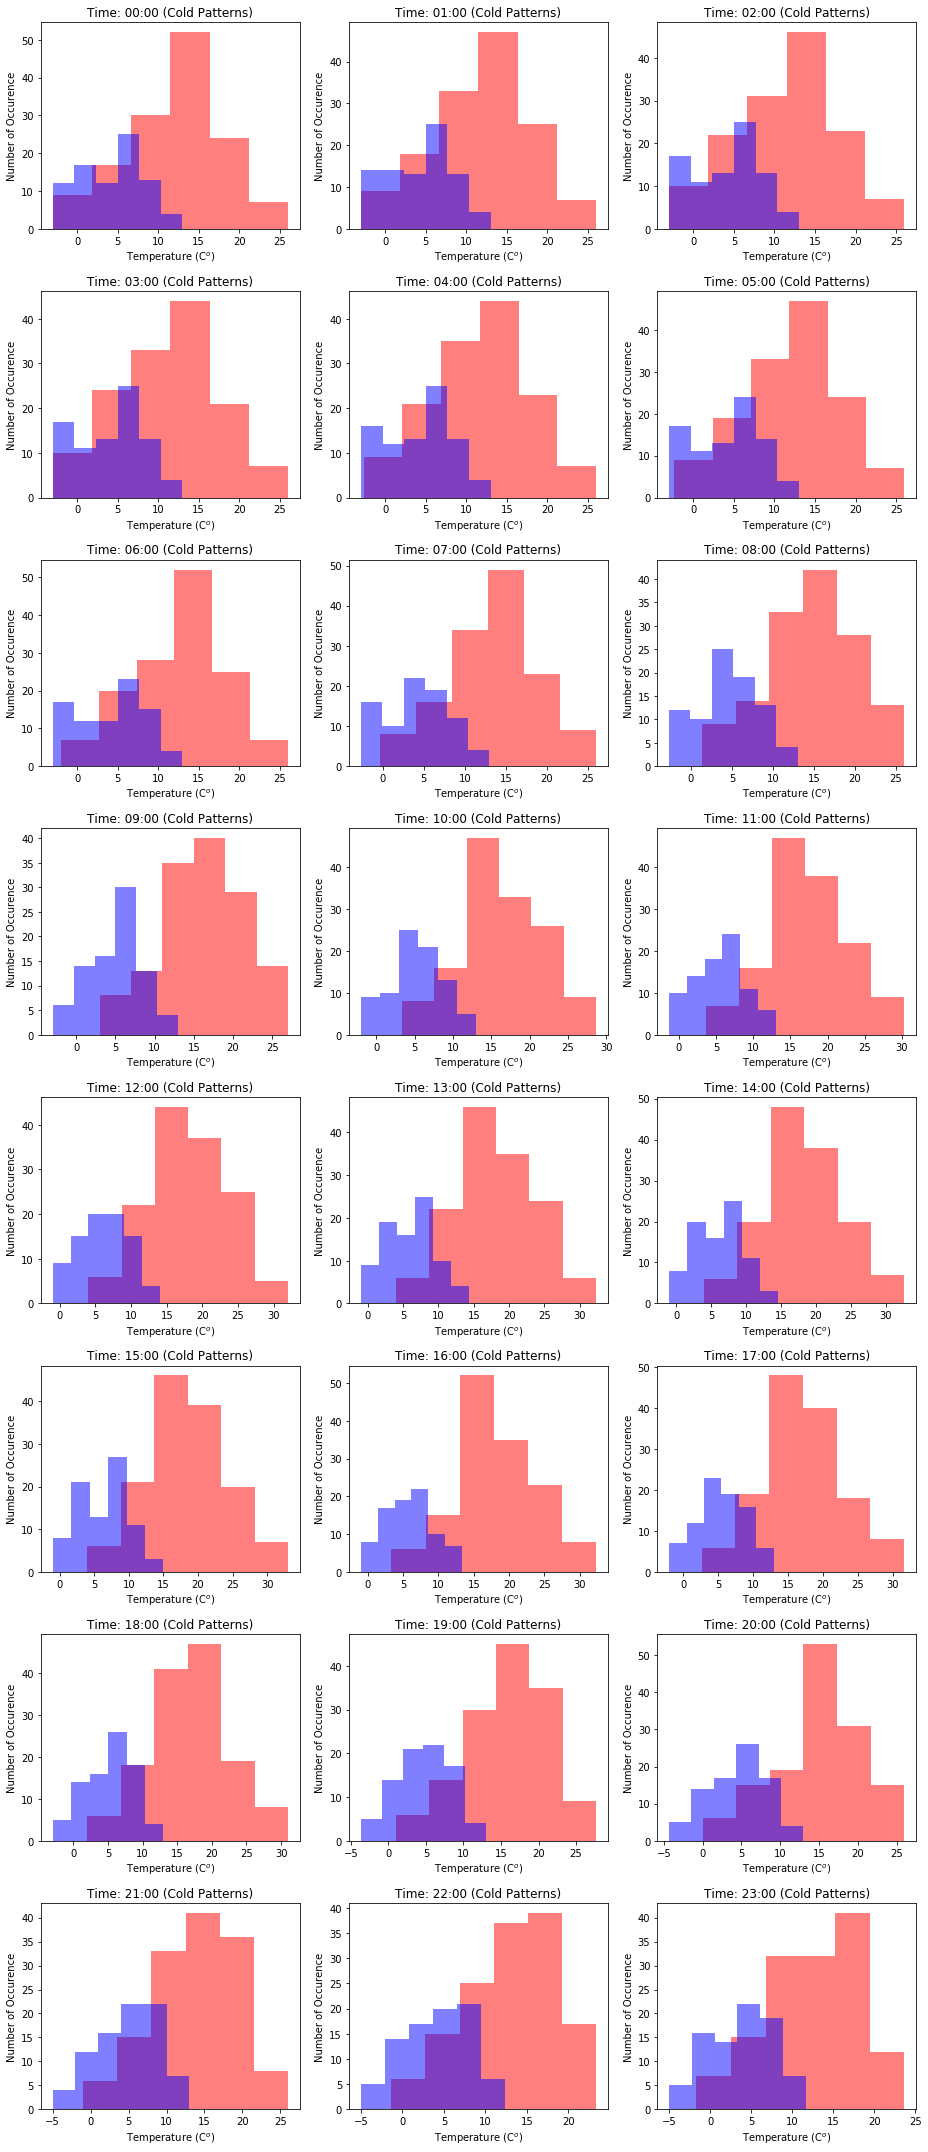

In [93]:
# temperature distribution of different hours of a day in a year
fig_all = plt.figure(figsize = (13,30))
for i in range(24):
    ax = fig_all.add_subplot(8, 3, i + 1)
    if i <= 9:
        ax.hist(df_wea1h_nf_warm[df_tou1h_nf_warm.GMT.str.contains('0' + str(i) + ':00:00')]['TempC'], bins=6, color = 'red', alpha = 0.5)
        ax.hist(df_wea1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains('0' + str(i) + ':00:00')]['TempC'], bins=6, color = 'blue', alpha = 0.5)
        ax.set_title('Time: 0' + str(i) + ':00' + ' (Cold Patterns)')
        ax.set_xlabel(r'Temperature (C$^o$)')
        ax.set_ylabel('Number of Occurence')
    else:
        ax.hist(df_wea1h_nf_warm[df_tou1h_nf_warm.GMT.str.contains(str(i) + ':00:00')]['TempC'], bins=6, color = 'red', alpha = 0.5)
        ax.hist(df_wea1h_nf_cold[df_tou1h_nf_cold.GMT.str.contains(str(i) + ':00:00')]['TempC'], bins=6, color = 'blue', alpha = 0.5)
        ax.set_title('Time: ' + str(i) + ':00' + ' (Cold Patterns)')
        ax.set_xlabel(r'Temperature (C$^o$)')
        ax.set_ylabel('Number of Occurence')
plt.tight_layout()

In [193]:
test2= pd.DataFrame(pd.to_datetime(test).dt.dayofweek)

In [114]:
test = df_wea1h_nf_cold['GMT'][df_wea1h_nf_cold.GMT.str.contains('23:00:00')]

In [177]:
test2

GMT
23      1
47      1
71      1
119     1
143     1
215     1
287     1
335     1
359     1
431     1
527     1
551     1
575     1
623     1
647     1
743     1
767     2
791     2
839     2
887     2
1031    2
1055    2
1079    2
1127    2
1199    2
1295    2
1319    2
1343    2
1487    3
1511    3
...   ...
7583   11
7607   11
7655   11
7679   11
7703   11
7727   11
7751   11
7775   11
7823   11
7847   11
7871   11
7895   11
8063   12
8087   12
8135   12
8159   12
8231   12
8255   12
8279   12
8351   12
8423   12
8447   12
8519   12
8543   12
8567   12
8591   12
8615   12
8663   12
8687   12
8759   12

[83 rows x 1 columns]

In [187]:
np.corrcoef(pca_nstd.components_[3], test2.GMT)[0][1]

0.29330018349026094

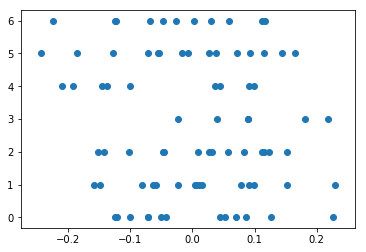

In [200]:
plt.scatter(pca_nstd.components_[6], test2)

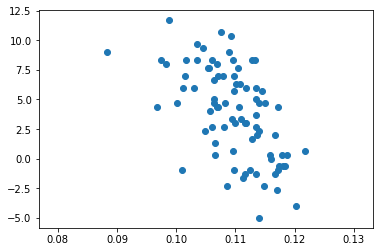

In [86]:
plt.scatter(pca.components_[0], df_wea1h_nf_cold.TempC[df_wea1h_nf_cold.GMT.str.contains('23:00:00')])

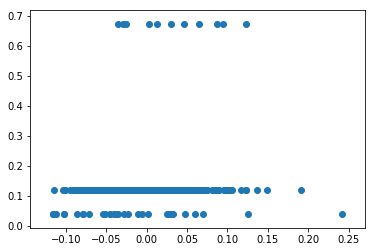

In [113]:
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.scatter(pca2.components_[11], df_tariff_1h.Price[df_tou1h.GMT.str.contains('09:00:00')])

In [101]:
df_tariff_1h

GMT   Price Event_tags
0     2013-01-01 00:00:00  0.1176        NaN
1     2013-01-01 01:00:00  0.1176        NaN
2     2013-01-01 02:00:00  0.1176        NaN
3     2013-01-01 03:00:00  0.1176        NaN
4     2013-01-01 04:00:00  0.1176        NaN
5     2013-01-01 05:00:00  0.1176        NaN
6     2013-01-01 06:00:00  0.1176        NaN
7     2013-01-01 07:00:00  0.1176        NaN
8     2013-01-01 08:00:00  0.1176        NaN
9     2013-01-01 09:00:00  0.1176        NaN
10    2013-01-01 10:00:00  0.1176        NaN
11    2013-01-01 11:00:00  0.1176        NaN
12    2013-01-01 12:00:00  0.1176        NaN
13    2013-01-01 13:00:00  0.1176        NaN
14    2013-01-01 14:00:00  0.1176        NaN
15    2013-01-01 15:00:00  0.1176        NaN
16    2013-01-01 16:00:00  0.1176        NaN
17    2013-01-01 17:00:00  0.1176        NaN
18    2013-01-01 18:00:00  0.1176        NaN
19    2013-01-01 19:00:00  0.1176        NaN
20    2013-01-01 20:00:00  0.1176        NaN
21    2013-01-01 21:00:00  0.1176        NaN
22    2013-01-01 22:00:00  0.1176        NaN
23    2013-01-01 23:00:00  0.1176        NaN
24    2013-01-02 00:00:00  0.1176        NaN
25    2013-01-02 01:00:00  0.1176        NaN
26    2013-01-02 02:00:00  0.1176        NaN
27    2013-01-02 03:00:00  0.1176        NaN
28    2013-01-02 04:00:00  0.1176        NaN
29    2013-01-02 05:00:00  0.1176        NaN
...                   ...     ...        ...
8730  2013-12-30 18:00:00  0.1176        NaN
8731  2013-12-30 19:00:00  0.1176        NaN
8732  2013-12-30 20:00:00  0.1176        NaN
8733  2013-12-30 21:00:00  0.1176        NaN
8734  2013-12-30 22:00:00  0.1176        NaN
8735  2013-12-30 23:00:00  0.1176        NaN
8736  2013-12-31 00:00:00  0.1176        NaN
8737  2013-12-31 01:00:00  0.1176        NaN
8738  2013-12-31 02:00:00  0.1176        NaN
8739  2013-12-31 03:00:00  0.1176        NaN
8740  2013-12-31 04:00:00  0.1176        NaN
8741  2013-12-31 05:00:00  0.1176        NaN
8742  2013-12-31 06:00:00  0.1176        NaN
8743  2013-12-31 07:00:00  0.1176        NaN
8744  2013-12-31 08:00:00  0.1176        NaN
8745  2013-12-31 09:00:00  0.1176        NaN
8746  2013-12-31 10:00:00  0.1176        NaN
8747  2013-12-31 11:00:00  0.1176        NaN
8748  2013-12-31 12:00:00  0.1176        NaN
8749  2013-12-31 13:00:00  0.1176        NaN
8750  2013-12-31 14:00:00  0.1176        NaN
8751  2013-12-31 15:00:00  0.1176        NaN
8752  2013-12-31 16:00:00  0.1176        NaN
8753  2013-12-31 17:00:00  0.1176        NaN
8754  2013-12-31 18:00:00  0.1176        NaN
8755  2013-12-31 19:00:00  0.1176        NaN
8756  2013-12-31 20:00:00  0.1176        NaN
8757  2013-12-31 21:00:00  0.1176        NaN
8758  2013-12-31 22:00:00  0.1176        NaN
8759  2013-12-31 23:00:00  0.1176        NaN

[8760 rows x 3 columns]

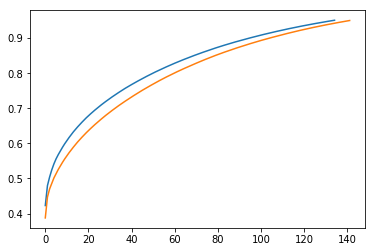

In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# Test with 9:00 am TOU data
y = df_tou1h_nf[df_tou1h_nf.GMT.str.contains('09:00:00')]
y.set_index('GMT', inplace = True)
y = y.transpose().dropna() # data for the specific hour, and filtering out null value
pca2 = PCA(0.95)
principleComponents2 = pca2.fit_transform(y)
principleDf2 = pd.DataFrame(data = principleComponents2)
plt.plot(np.cumsum(pca2.explained_variance_ratio_))
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [54]:
y = df_Ntou1h[df_Ntou1h.GMT.str.contains('09:00:00')]
y.set_index('GMT', inplace = True)
y = y.transpose()
y.dropna()

GMT    2013-01-01 09:00:00  2013-01-02 09:00:00  2013-01-03 09:00:00  \
N0000                0.448                0.528                0.619   
N0001                0.228                0.243                0.263   
N0002                0.238                0.594                0.487   
N0003                0.598                0.543                0.371   
N0004                0.305                0.344                0.417   
N0007                0.167                0.163                0.166   
N0008                0.151                0.480                0.627   
N0009                0.947                0.852                0.801   
N0010                0.576                0.585                0.714   
N0011                0.490                0.563                0.491   
N0012                0.466                0.197                0.194   
N0013                0.364                0.641                0.501   
N0014                1.061                1.984                2.970   
N0016                0.011                0.011                0.668   
N0017                0.057                0.044                0.045   
N0018                0.131                0.111                0.093   
N0020                0.244                0.232                0.127   
N0021                0.414                0.440                0.527   
N0022                1.490                1.370                1.206   
N0023                0.781                0.736                0.361   
N0024                2.745                3.099                1.070   
N0025                0.295                0.187                0.187   
N0027                0.342                0.518                0.492   
N0028                0.243                0.153                0.151   
N0029                0.374                2.320                3.662   
N0030                0.155                0.149                0.147   
N0034                1.015                0.267                0.351   
N0035                0.416                0.374                0.153   
N0039                0.206                0.209                0.226   
N0040                1.770                1.579                1.648   
...                    ...                  ...                  ...   
N4136                0.132                0.112                0.102   
N4137                0.165                0.272                0.526   
N4138                0.328                0.263                0.367   
N4139                0.281                0.283                0.260   
N4140                0.177                0.356                0.601   
N4141                0.300                0.124                0.300   
N4142                0.675                0.548                0.547   
N4144                0.479                0.467                0.443   
N4145                0.217                0.280                0.080   
N4146                0.222                0.067                0.653   
N4147                0.170                0.452                0.485   
N4148                0.244                0.228                0.567   
N4149                0.137                0.088                0.084   
N4150                1.658                1.616                2.407   
N4152                0.164                0.216                0.081   
N4154                0.169                0.406                0.385   
N4155                3.655                0.140                0.163   
N4156                0.178                0.230                0.173   
N4157                0.215                0.349                0.648   
N4159                0.498                0.417                0.484   
N4162                0.093                2.045                0.147   
N4163                0.337                0.233                0.386   
N4164                0.113                0.054                0.091   
N4165                0.070              